   Channel  DAC     mean_ADC    std_ADC     mean_TOT     std_TOT
0        1  300   724.750000  52.696458   334.250000  222.899641
1        1  400  1019.666667   4.932883   853.333333    4.618802
2        1  450  1019.250000   4.349329  1206.000000  210.180874
3        2  300   714.750000  61.190277   326.750000  217.846085
4        2  400  1021.666667   2.309401   776.000000    8.000000


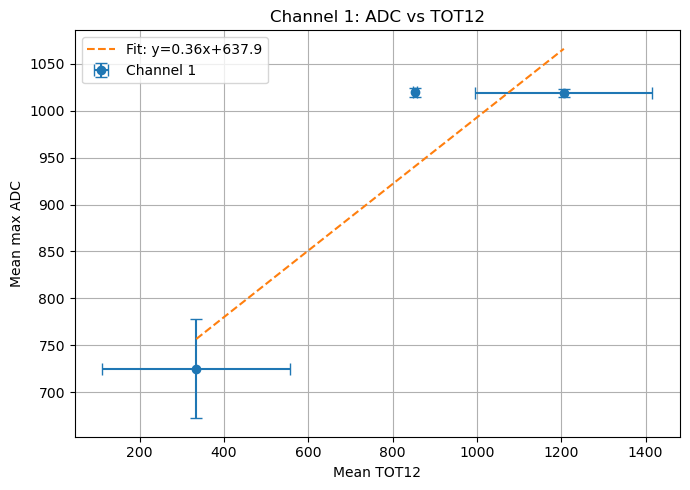

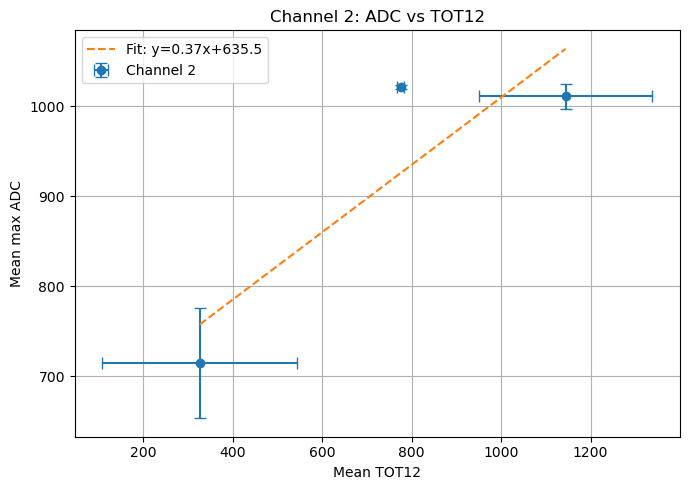

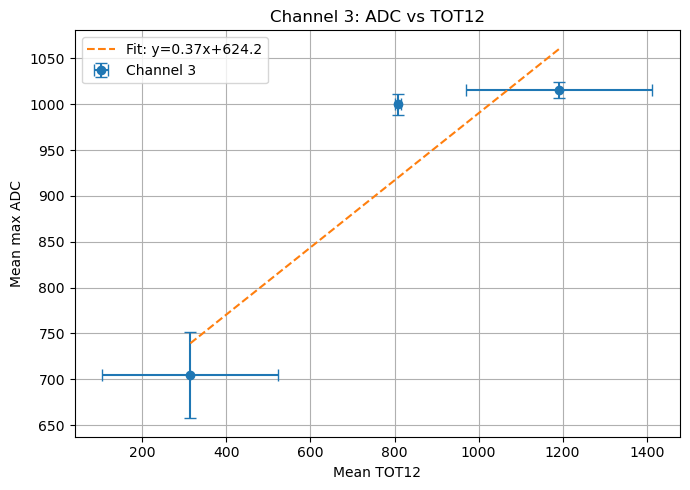

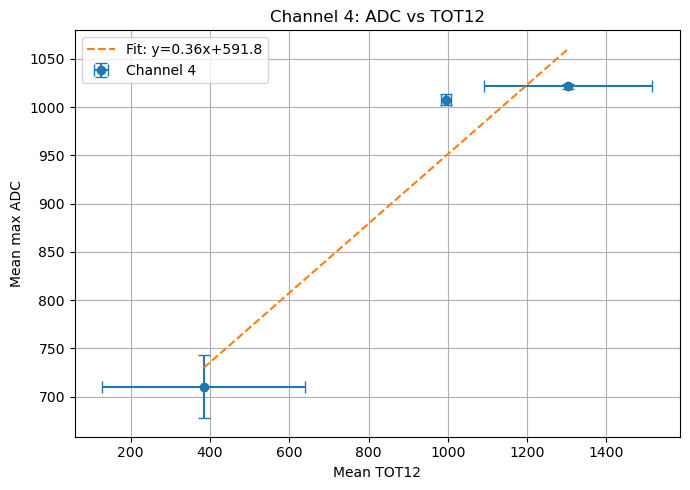

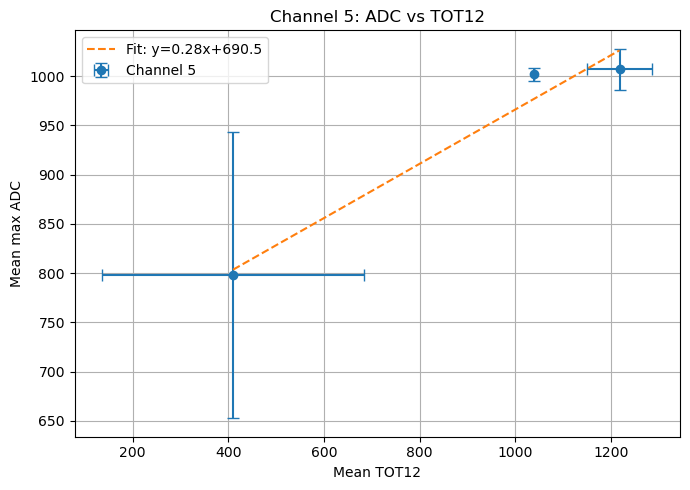

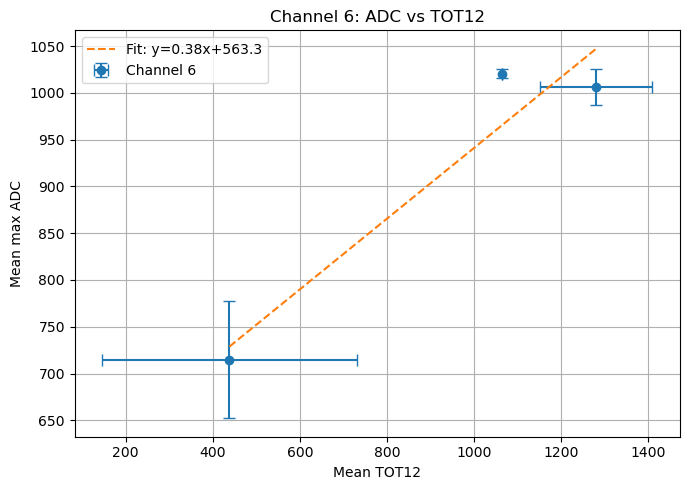

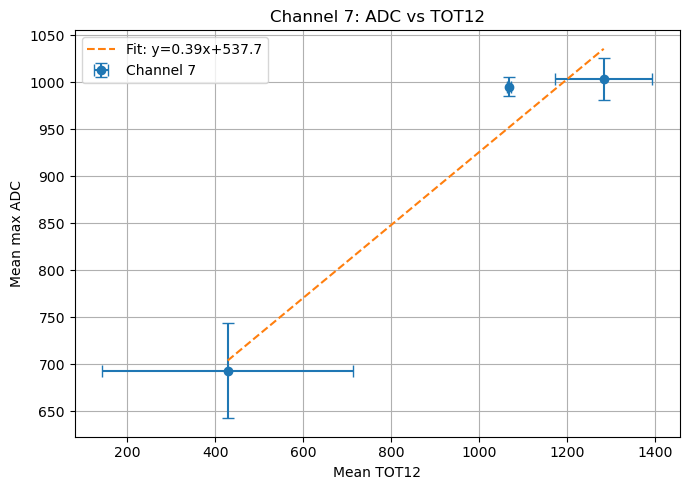

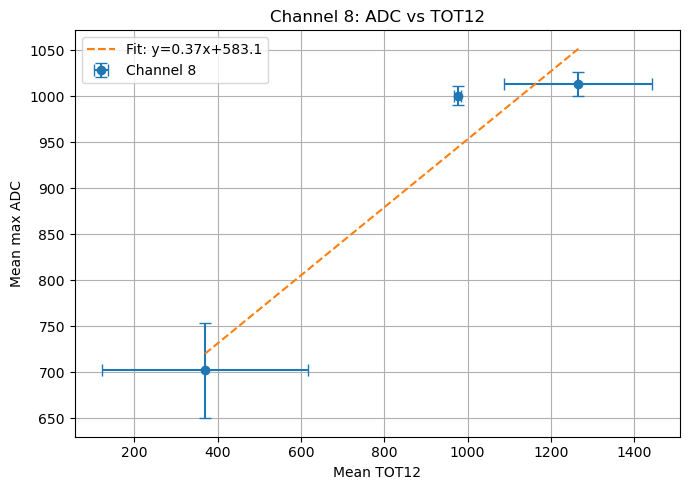

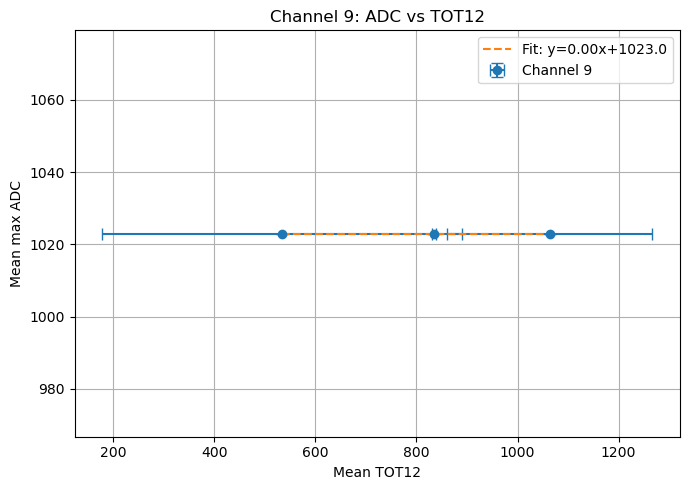

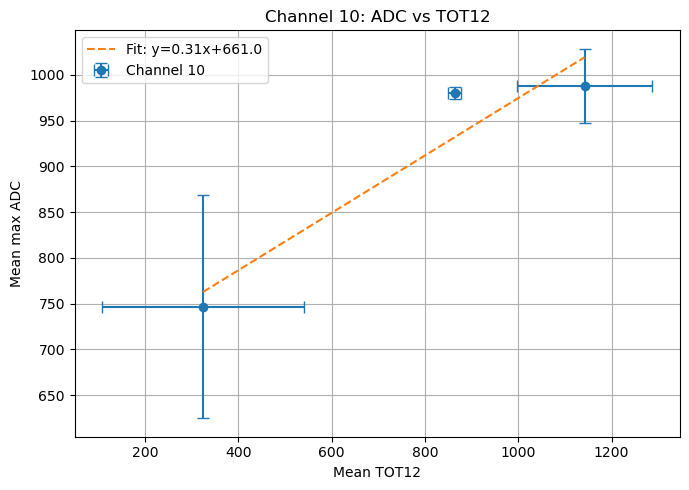

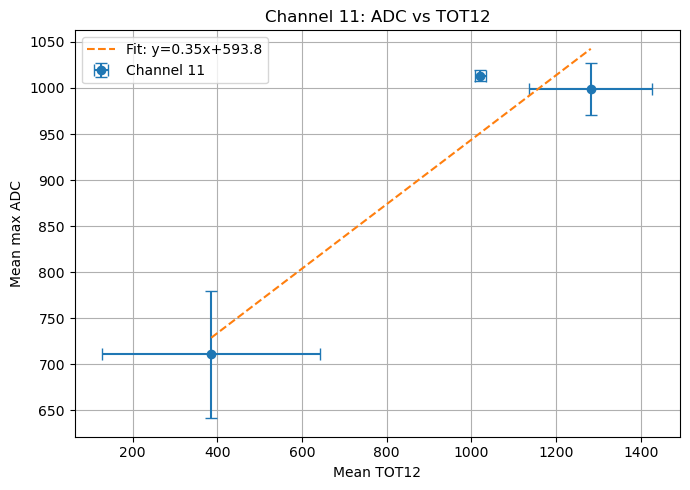

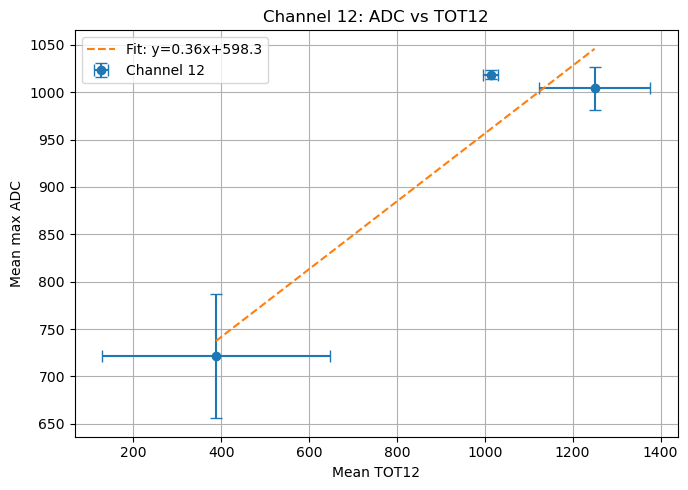

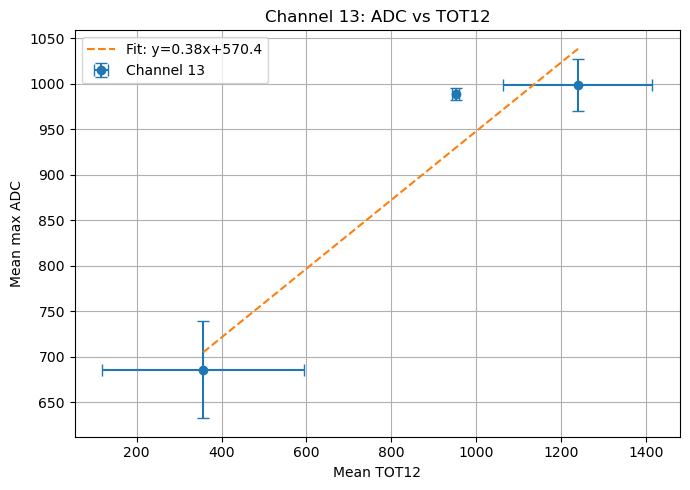

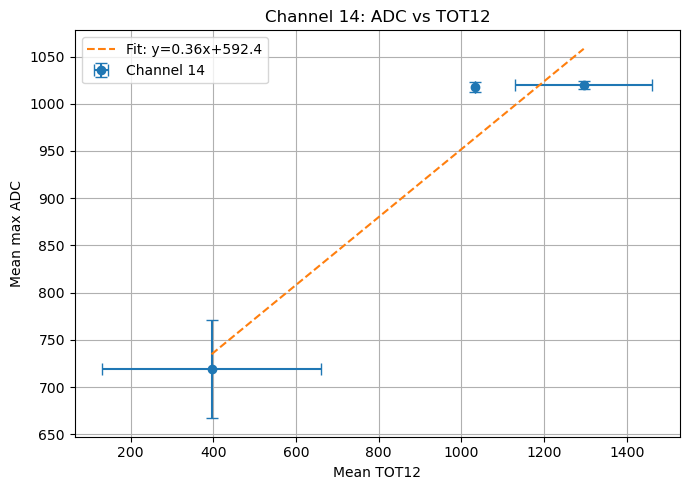

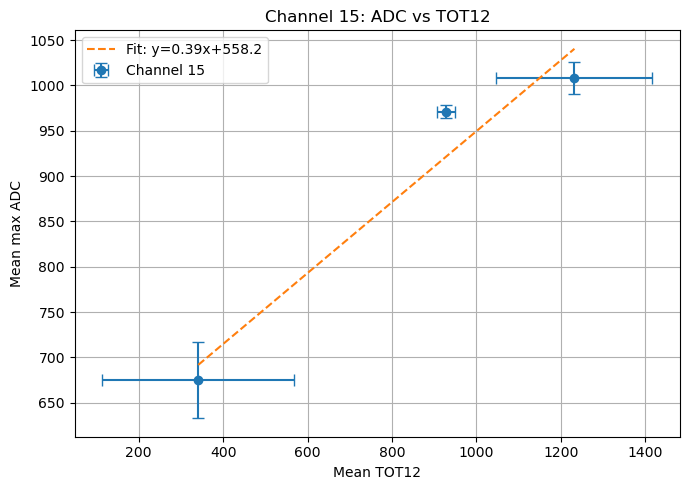

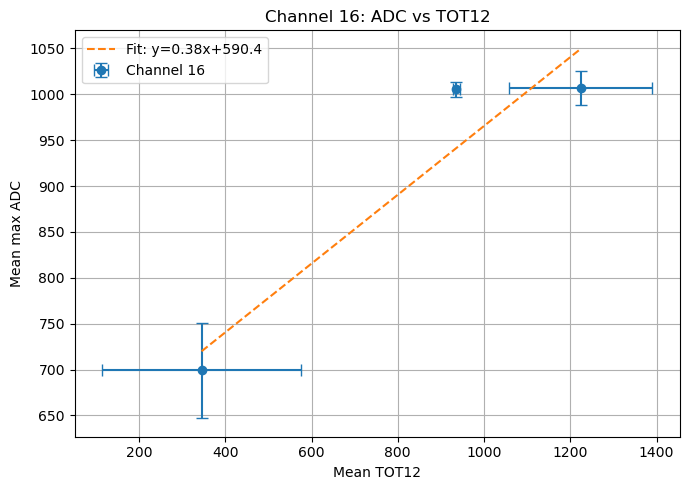

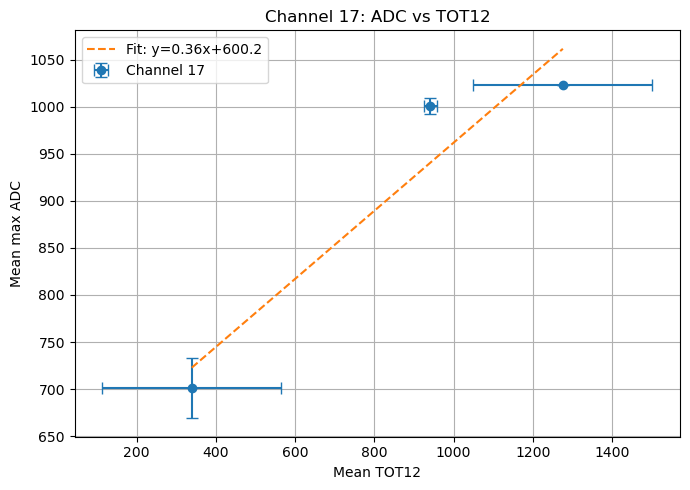

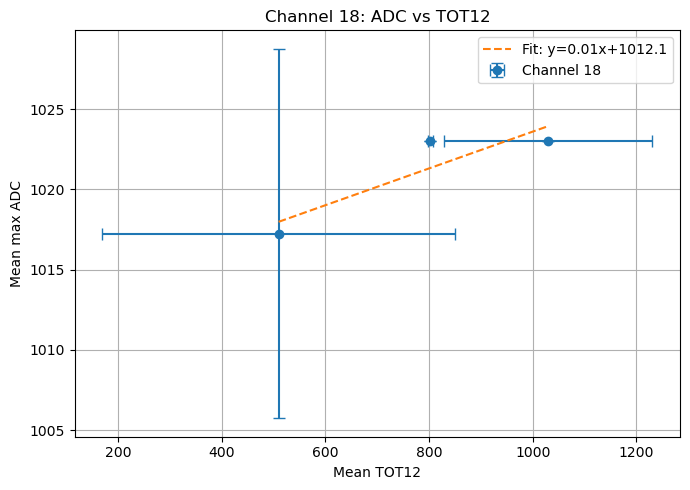

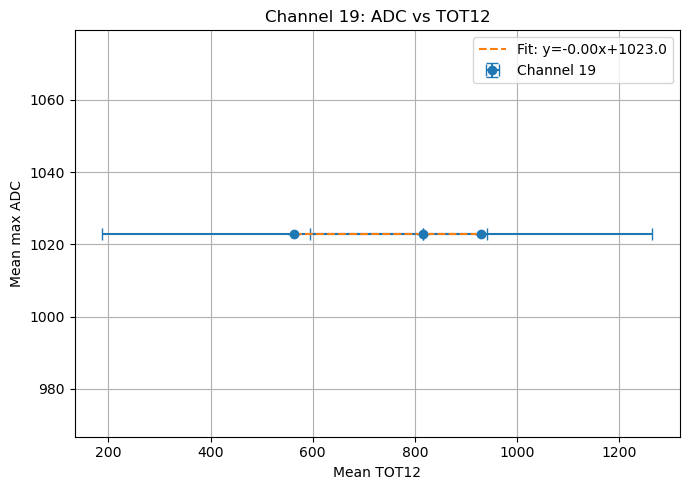

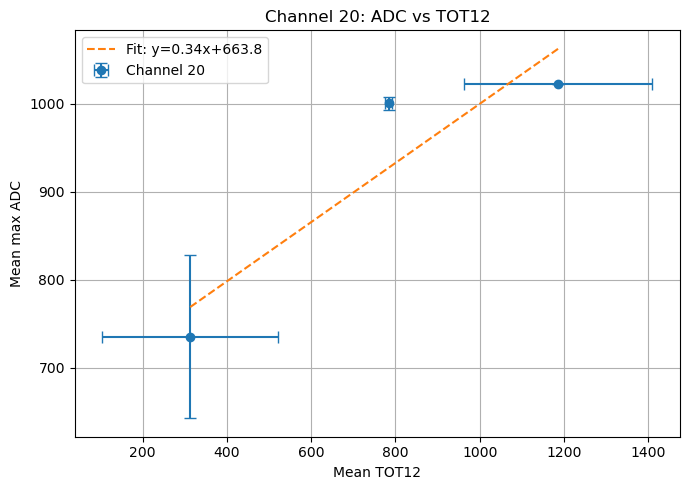

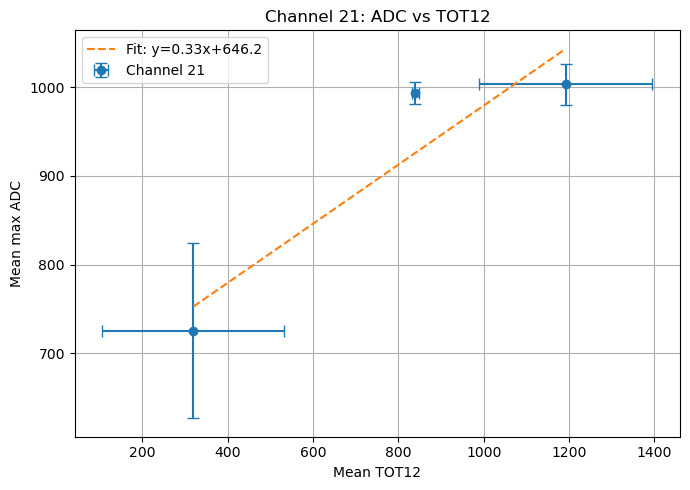

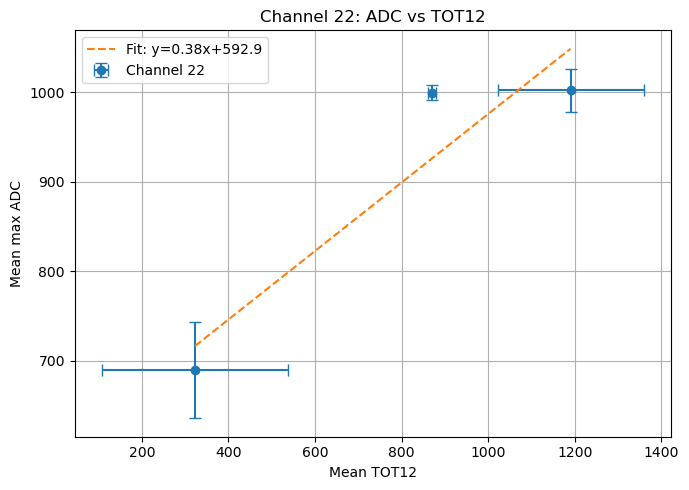

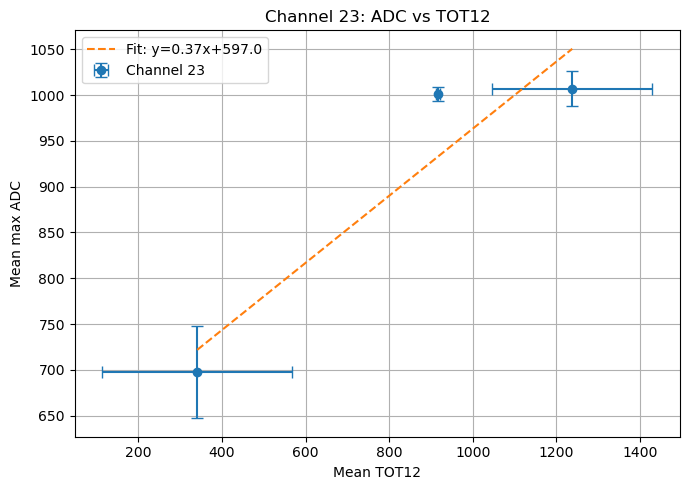

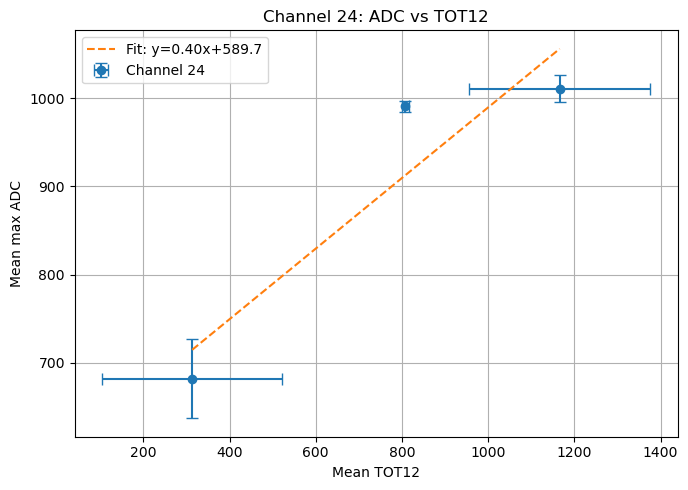

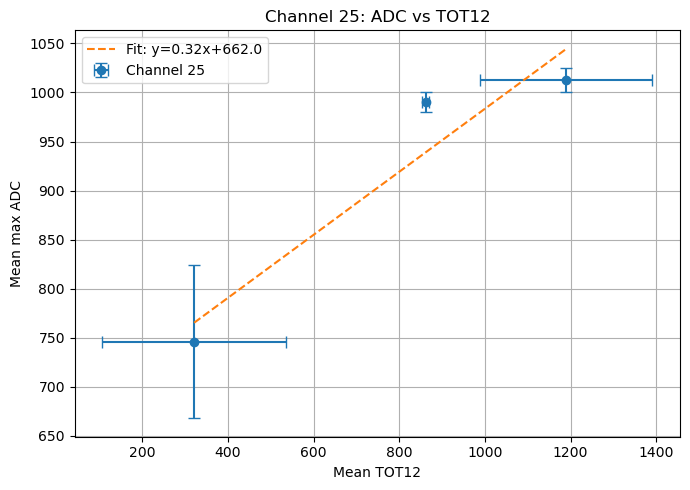

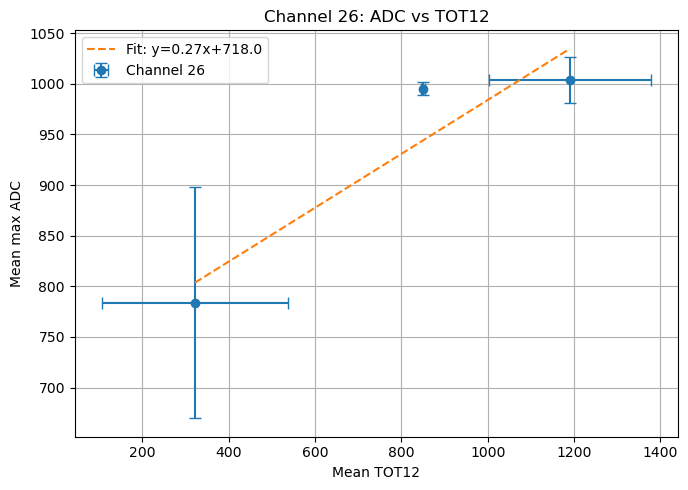

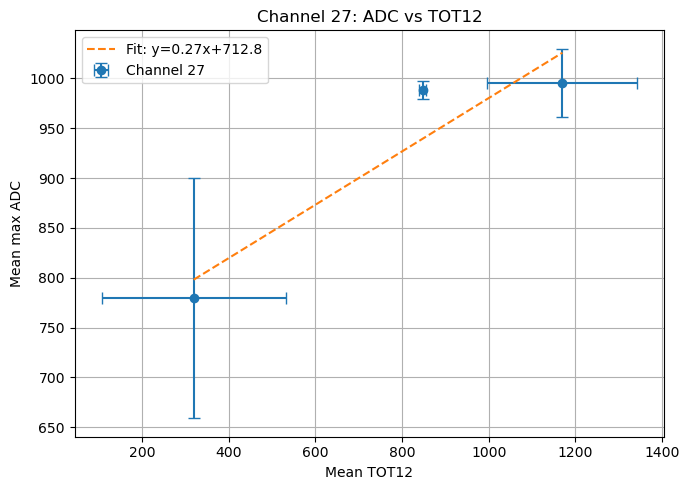

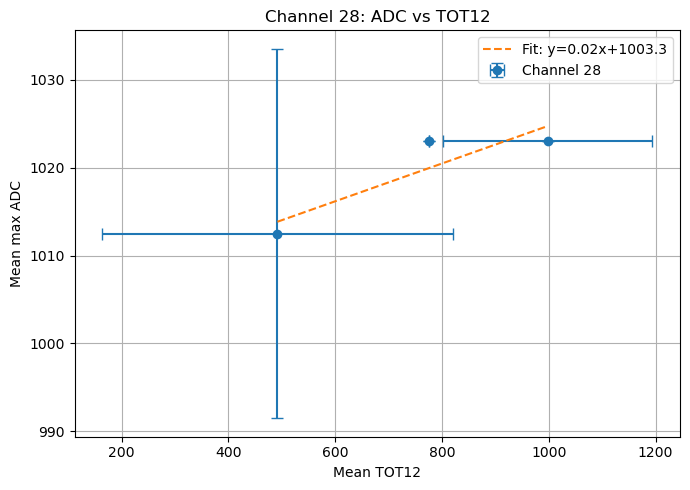

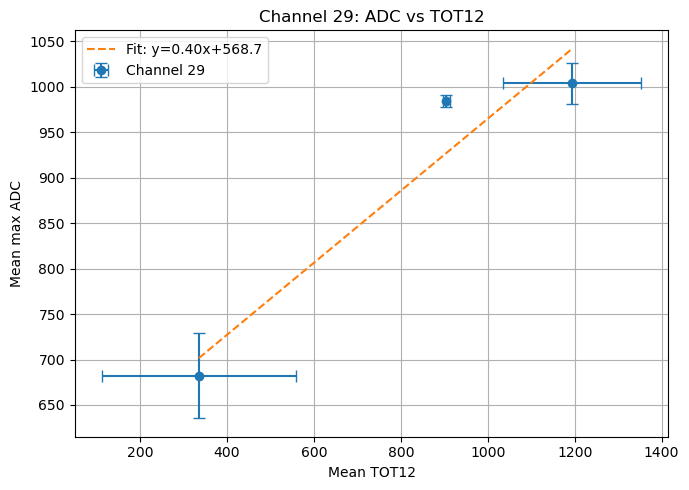

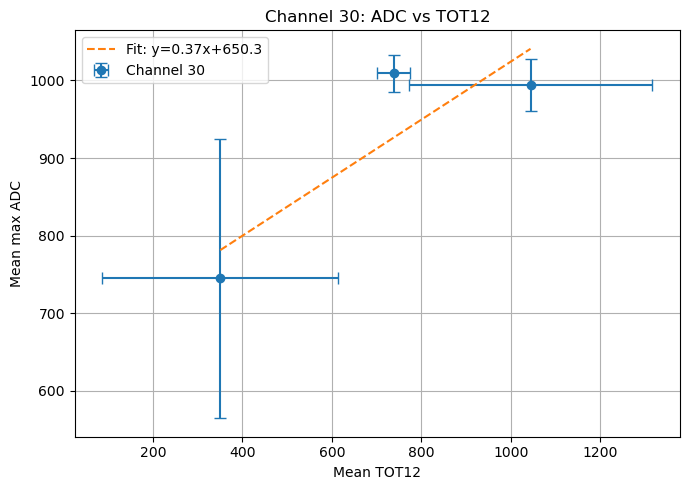

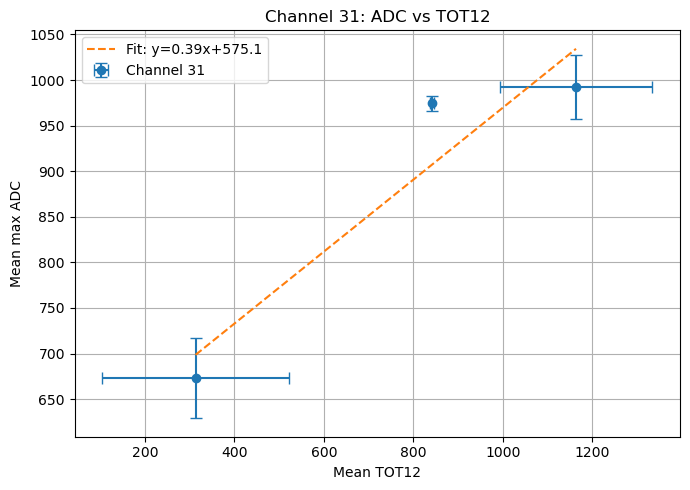

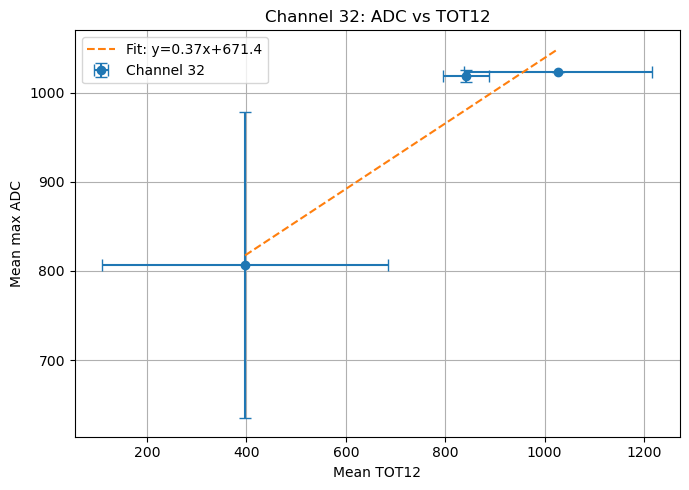

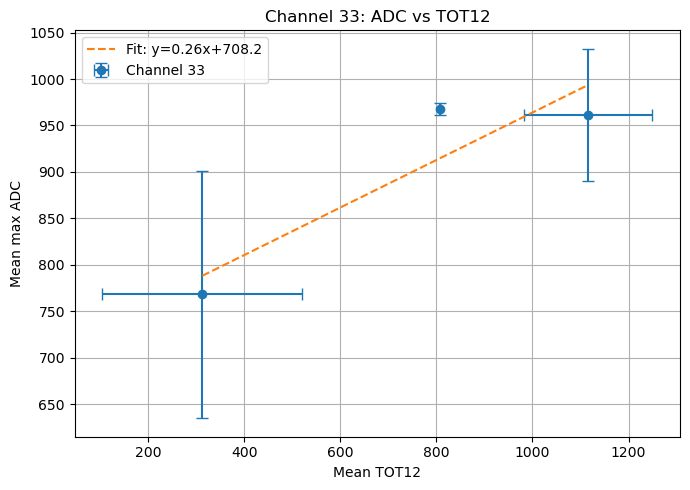

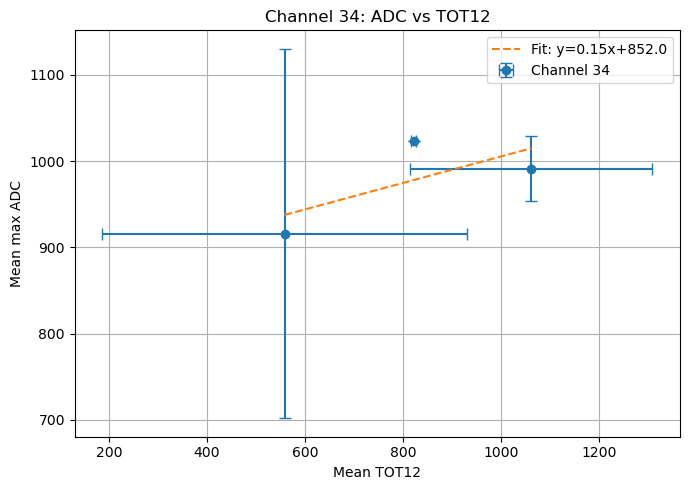

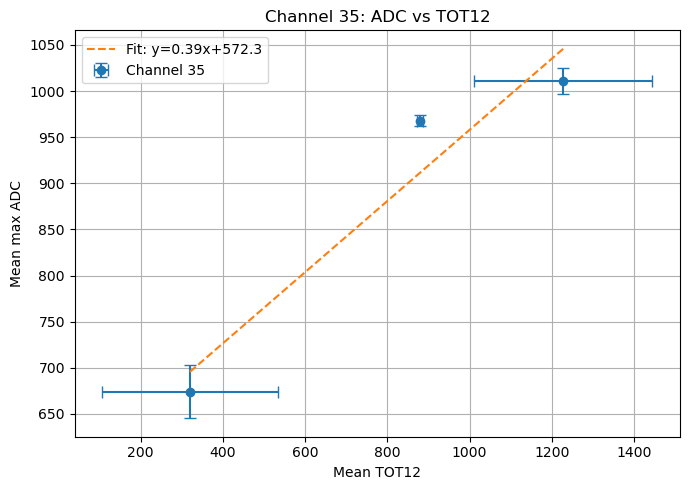

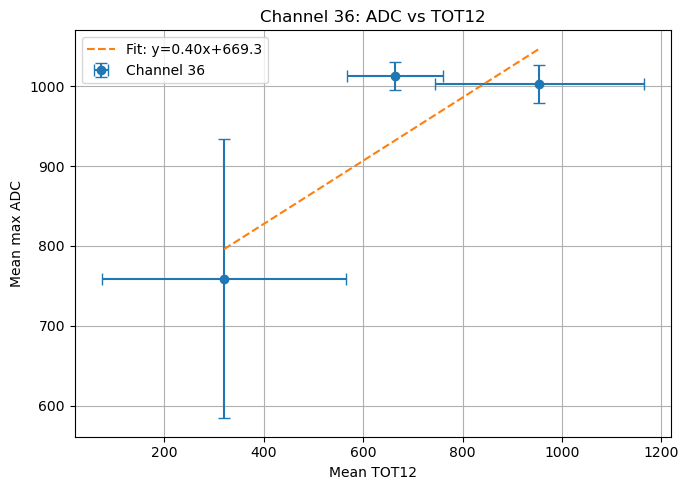

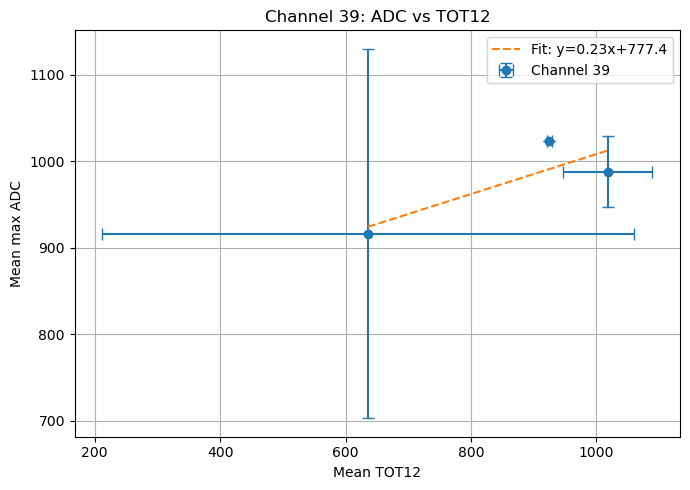

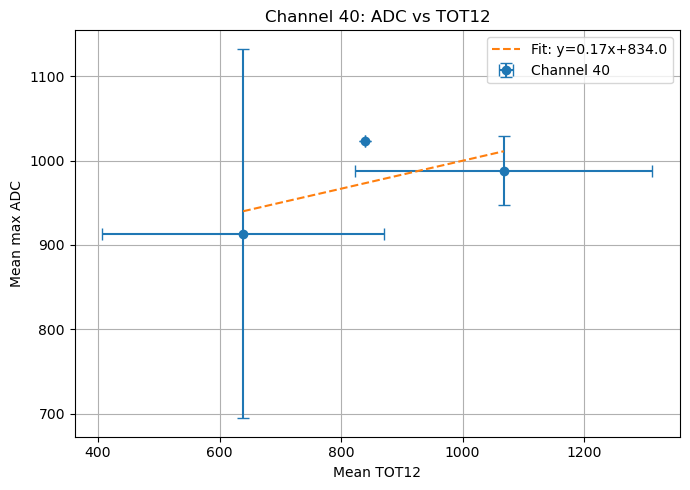

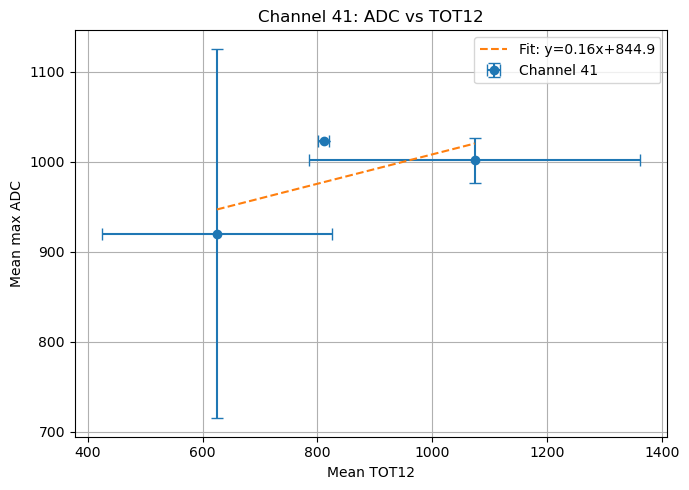

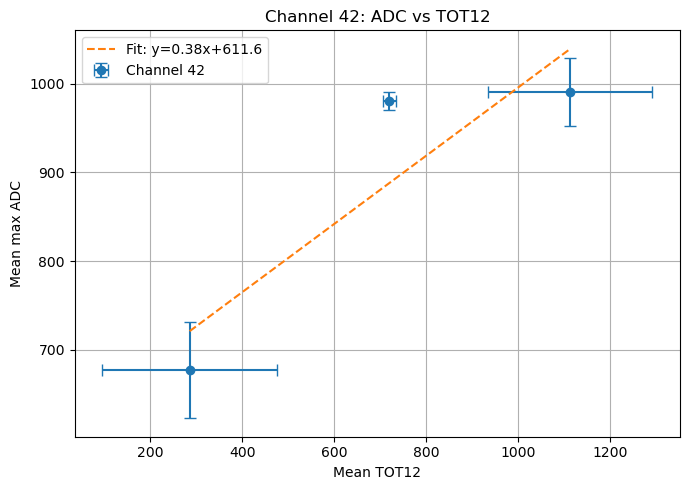

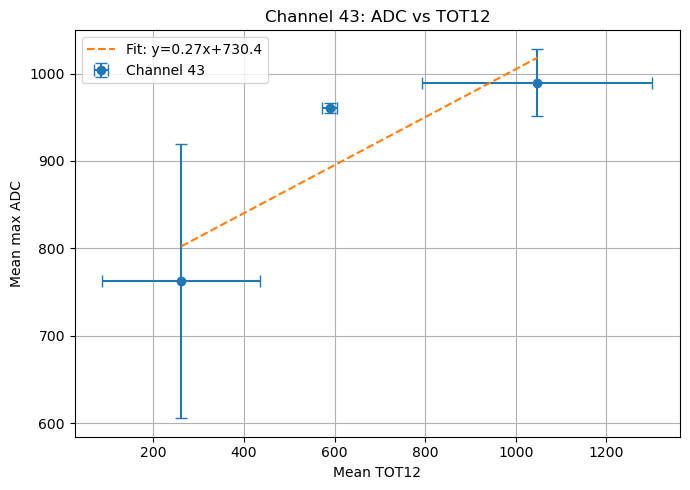

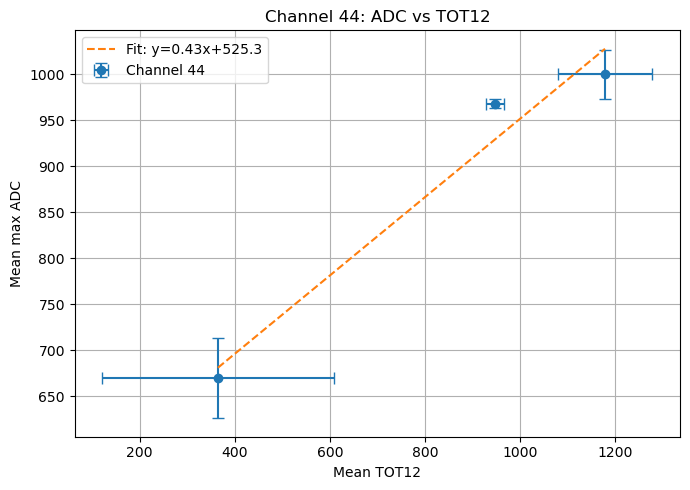

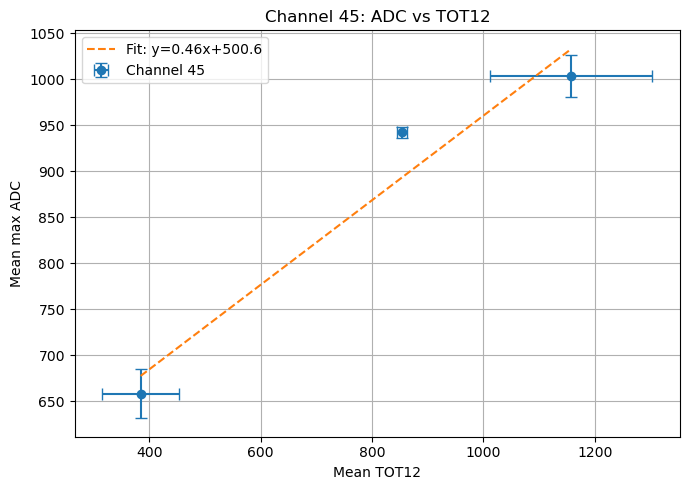

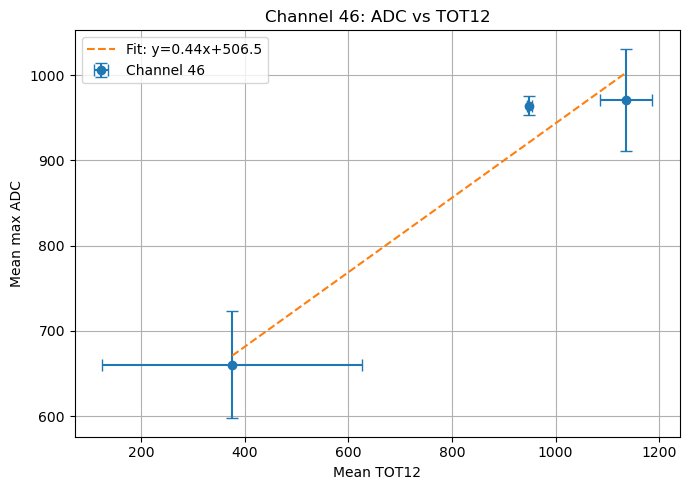

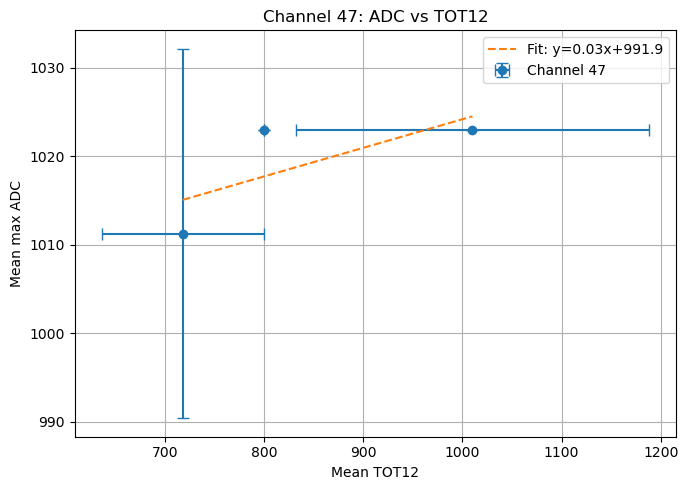

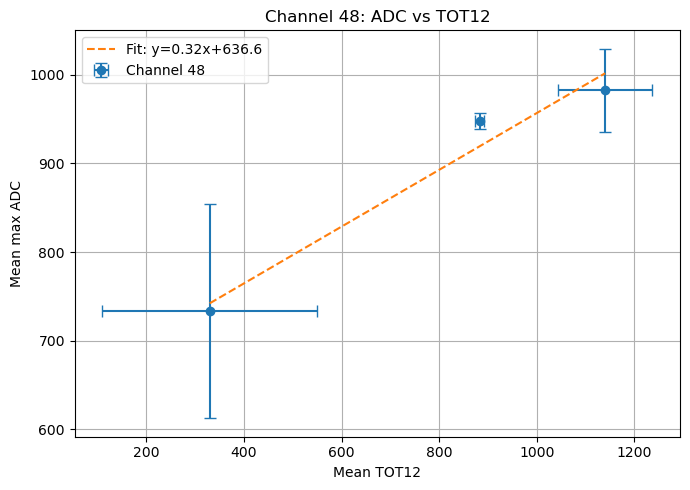

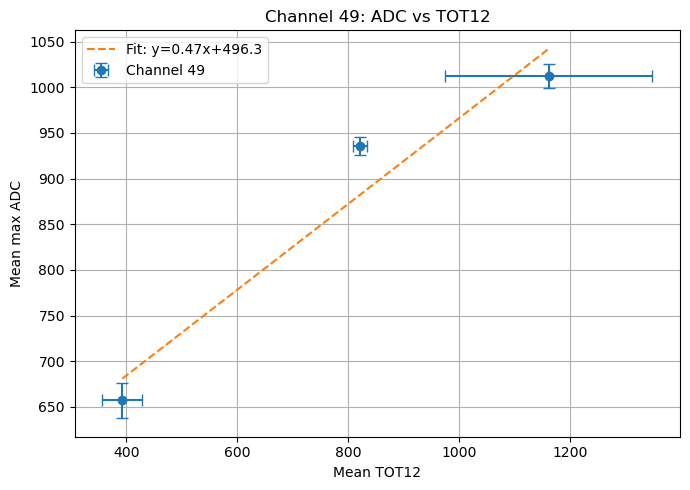

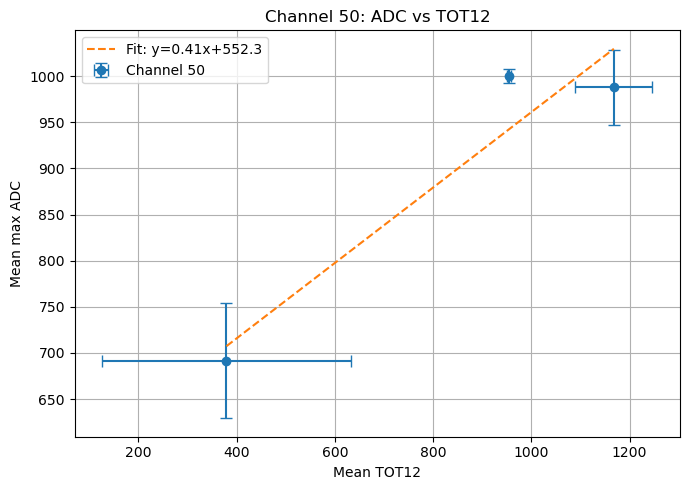

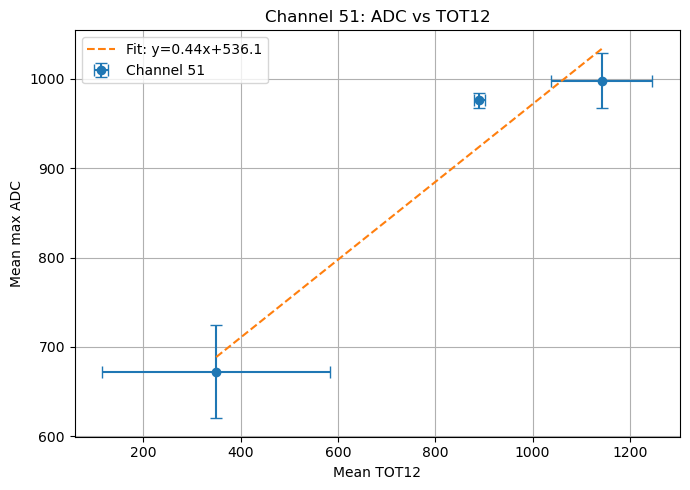

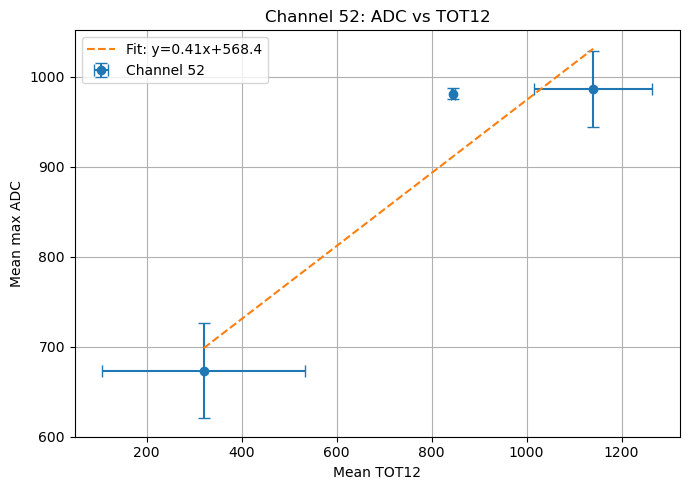

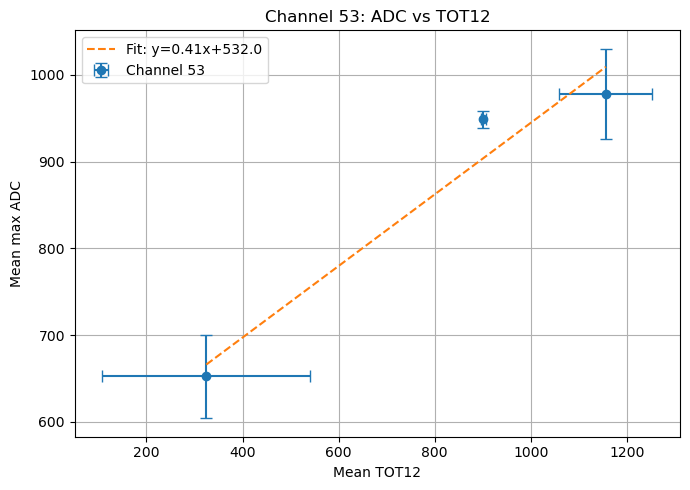

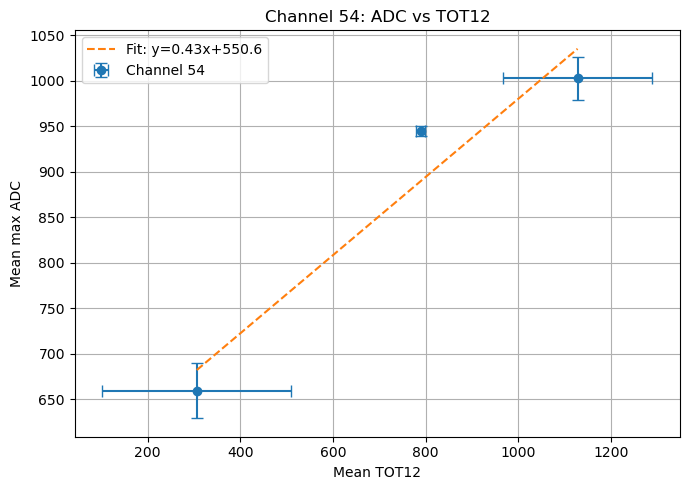

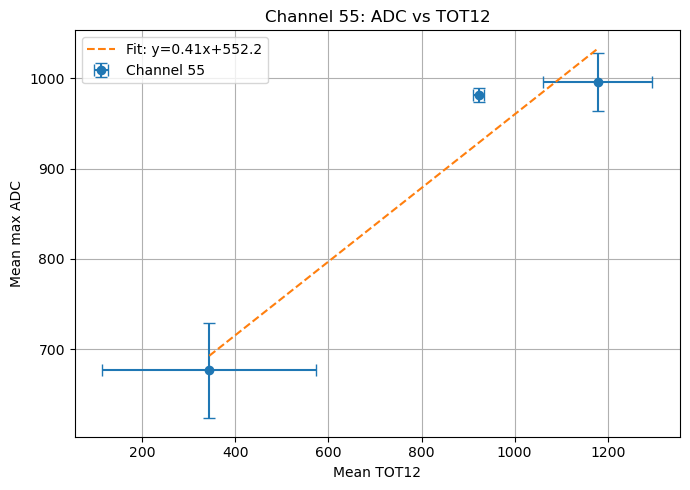

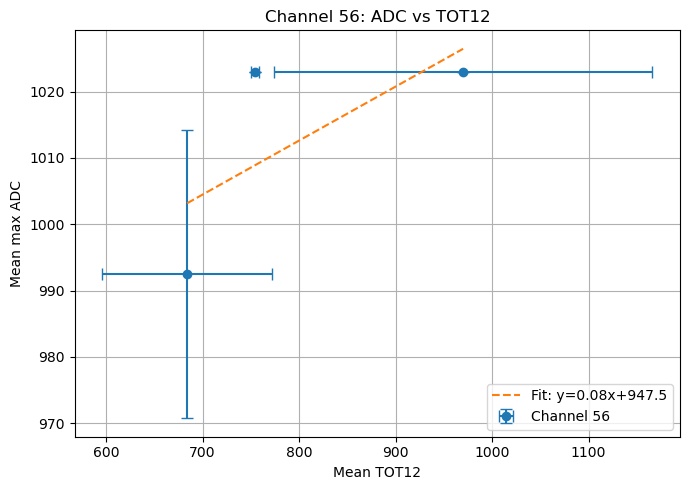

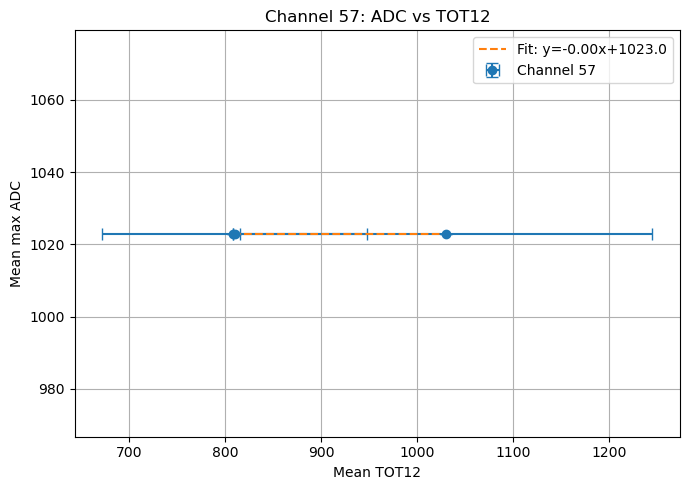

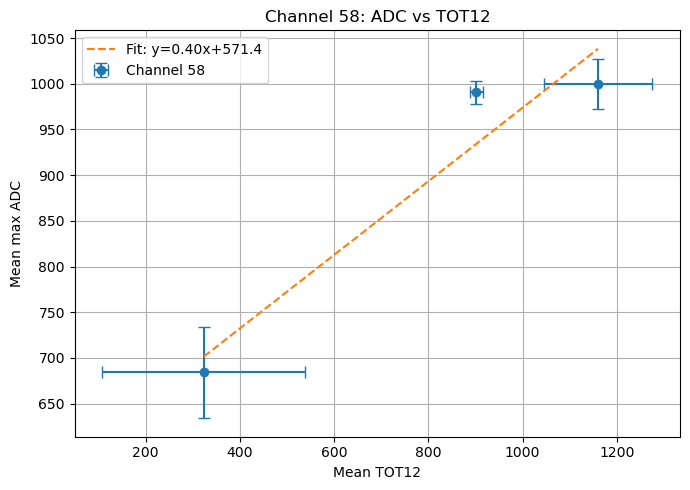

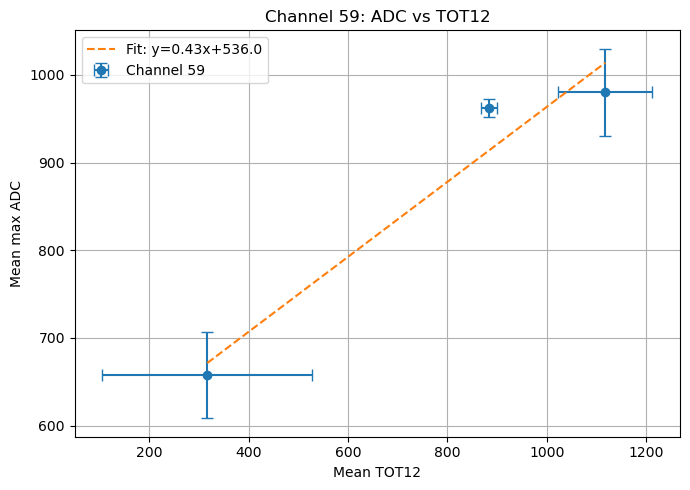

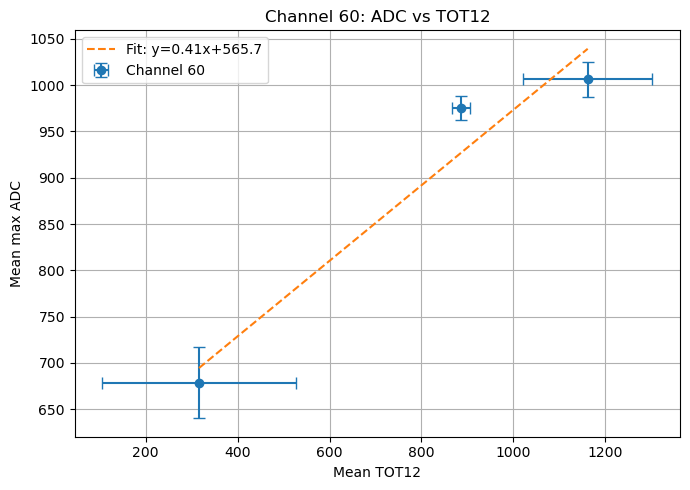

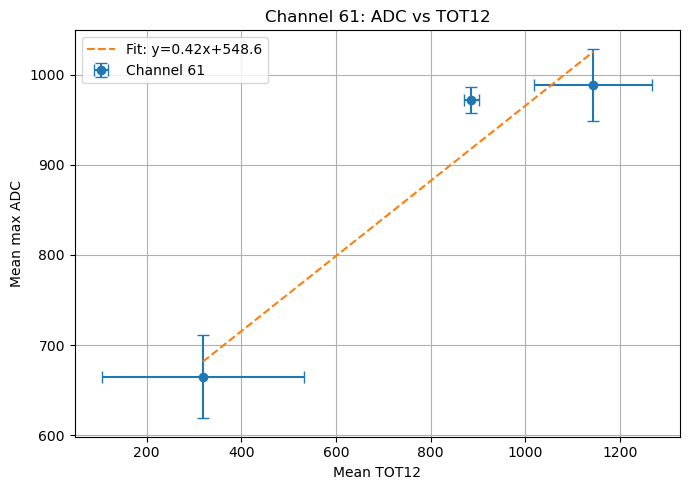

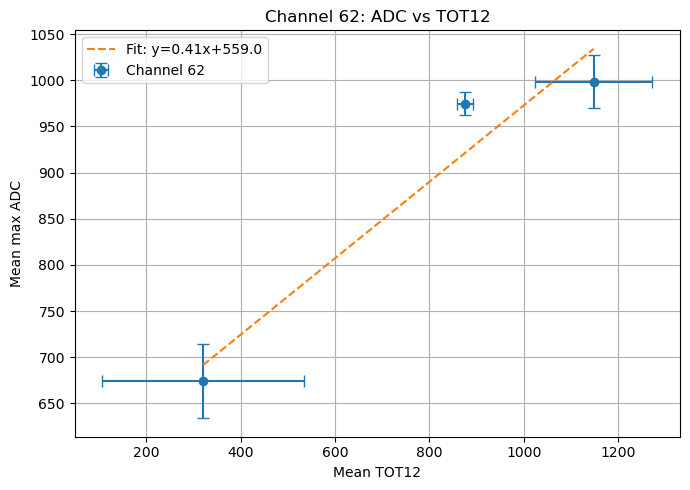

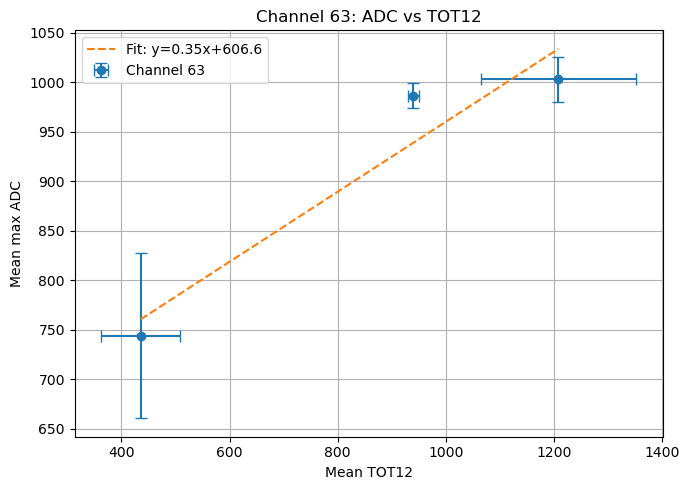

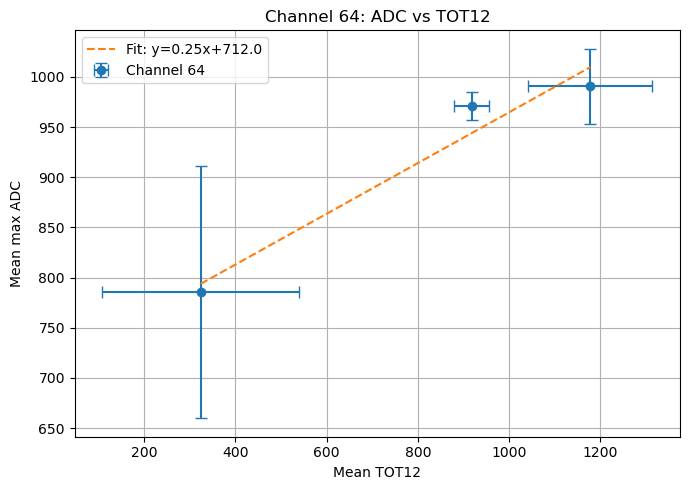

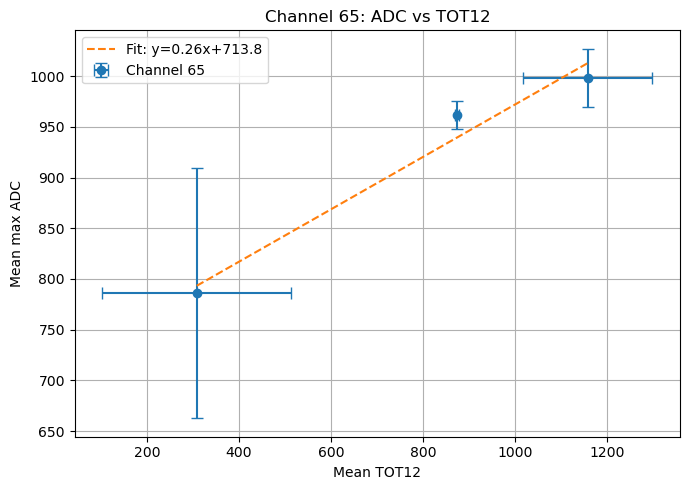

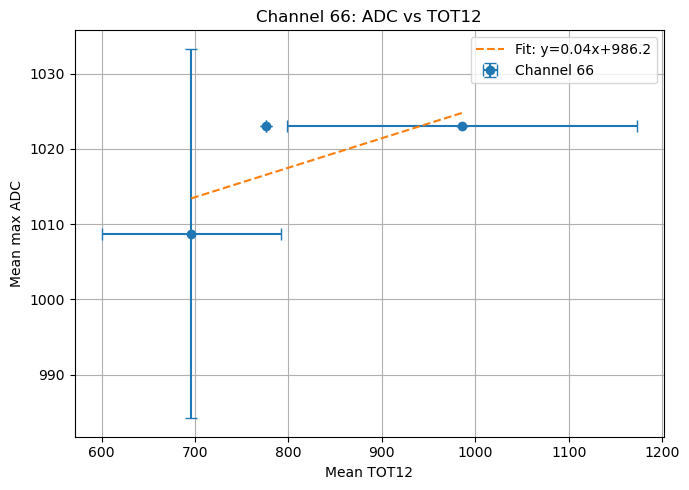

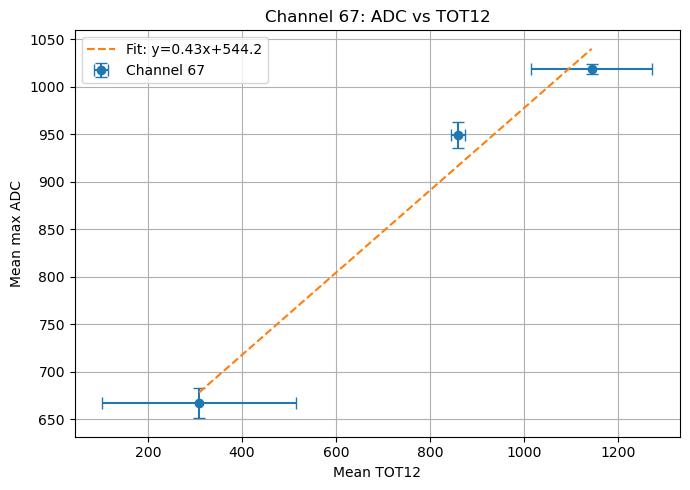

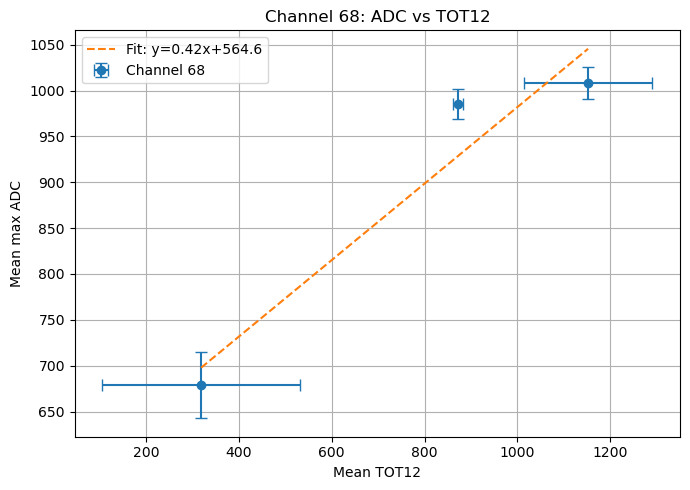

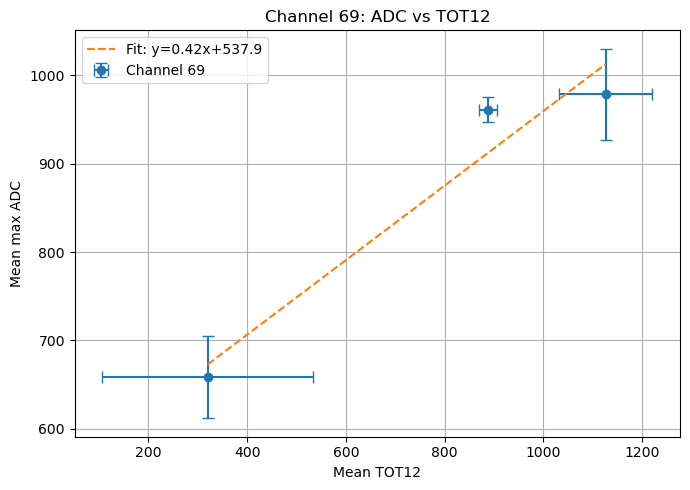

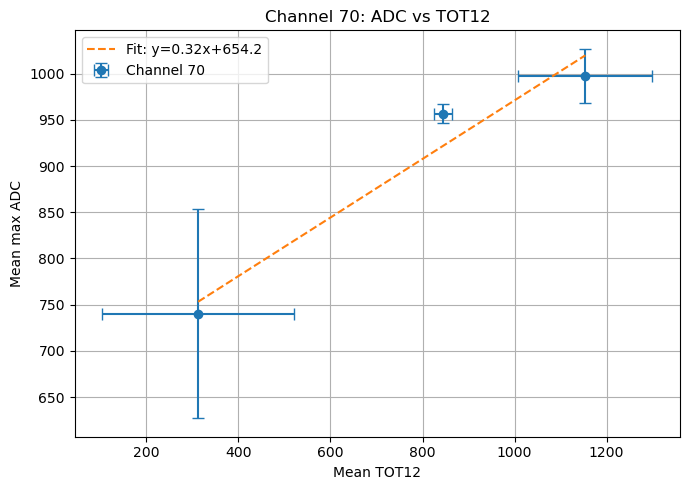

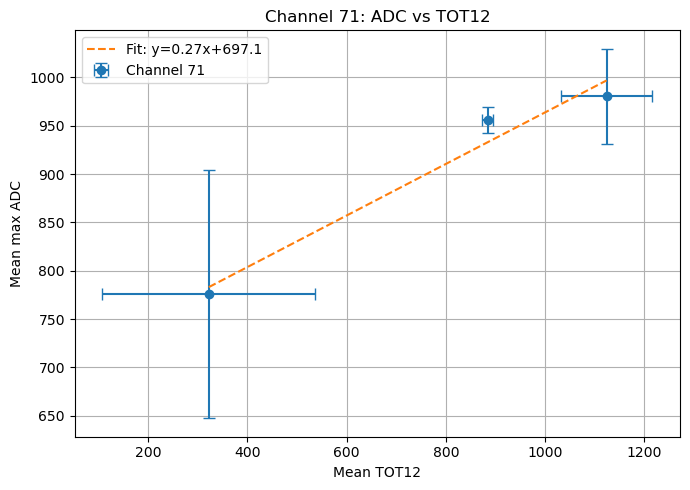

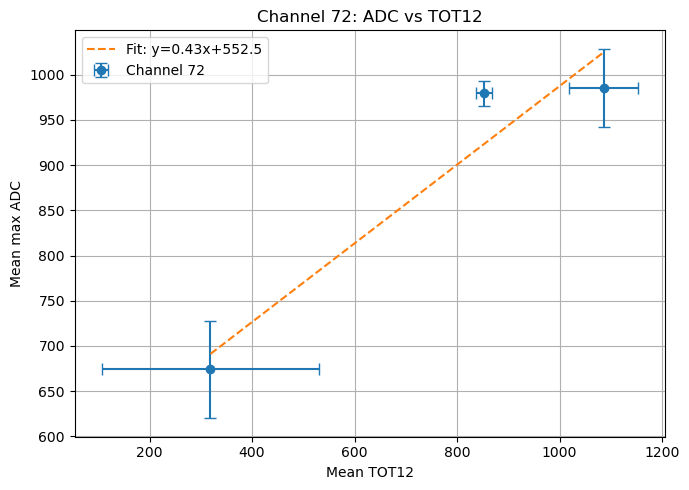

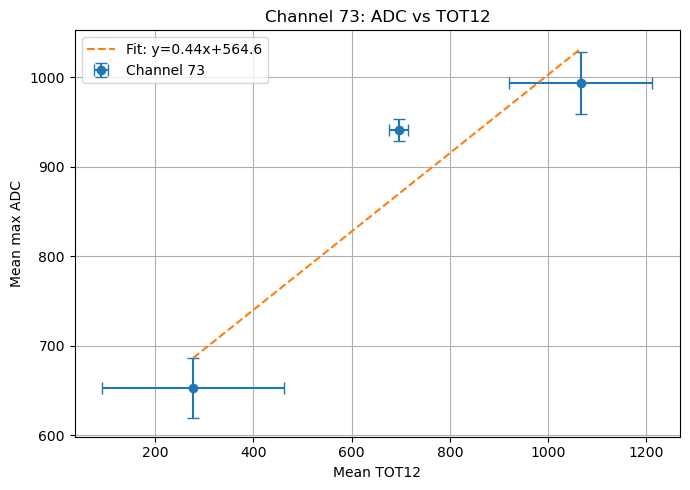

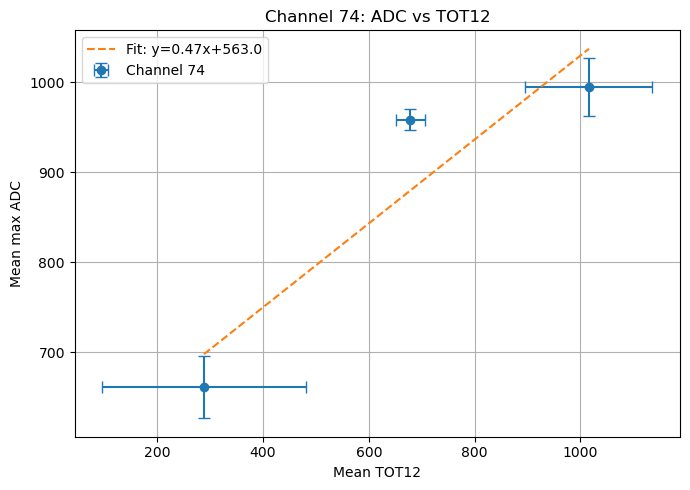

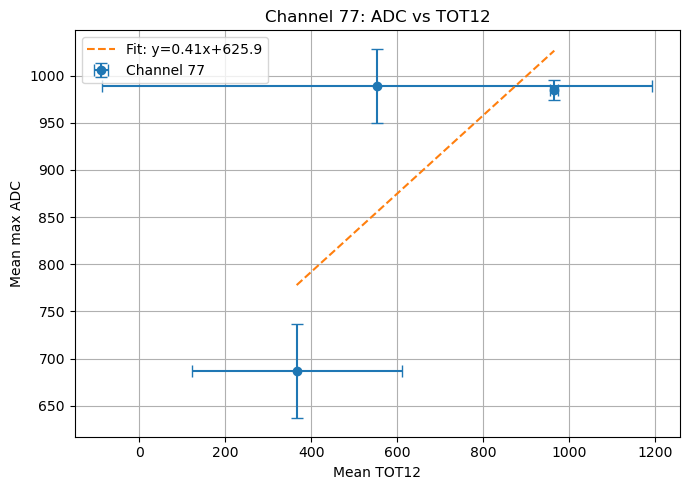

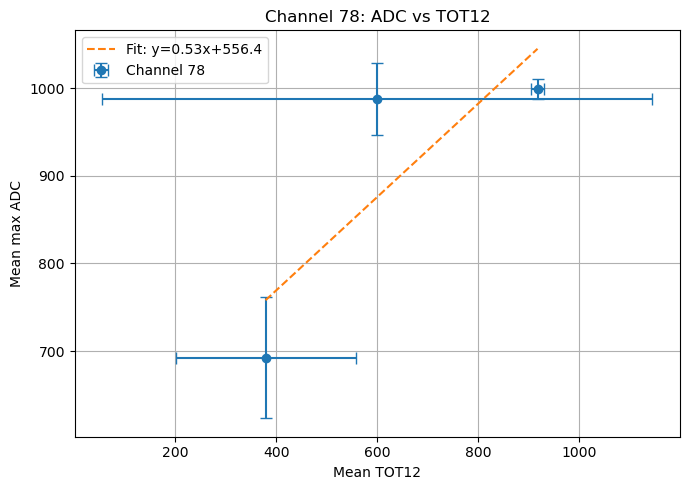

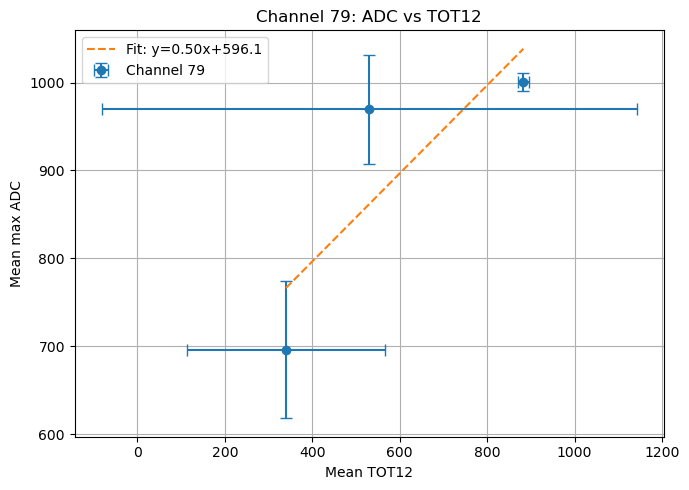

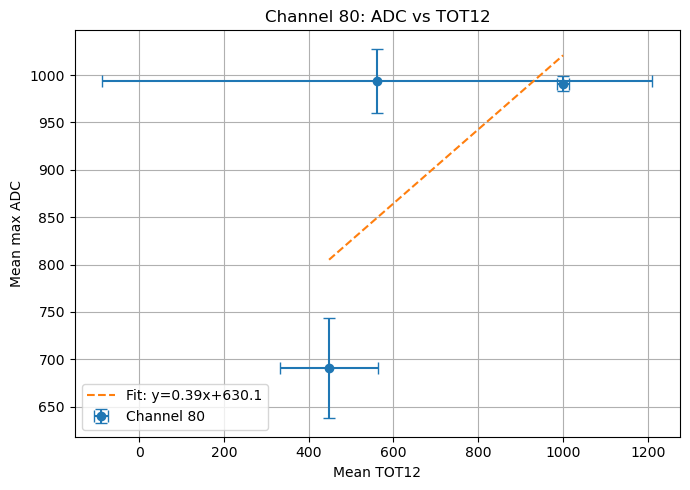

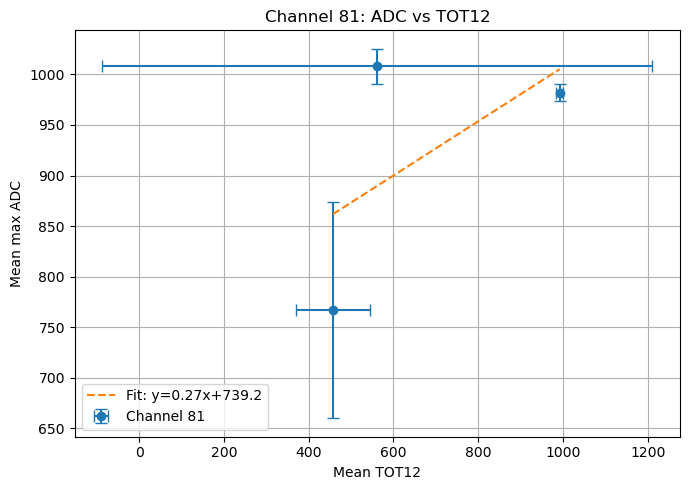

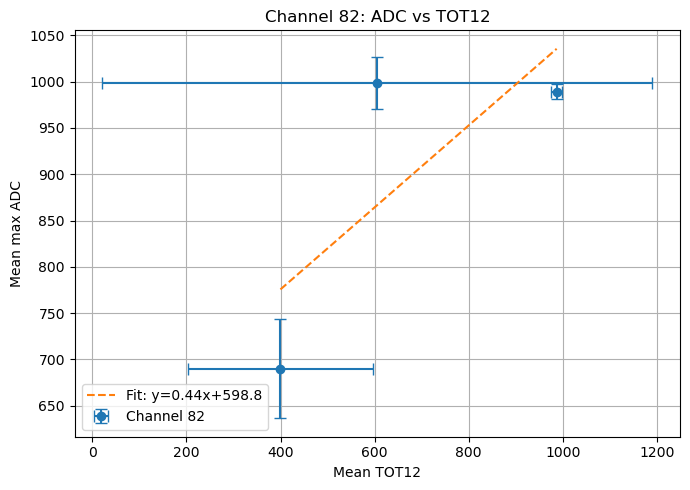

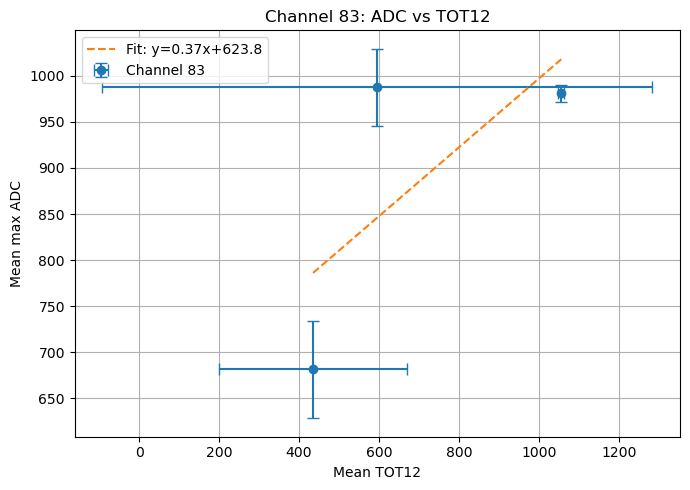

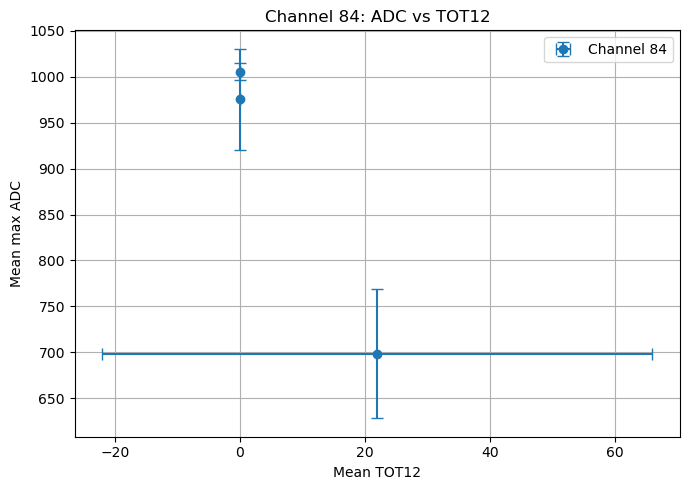

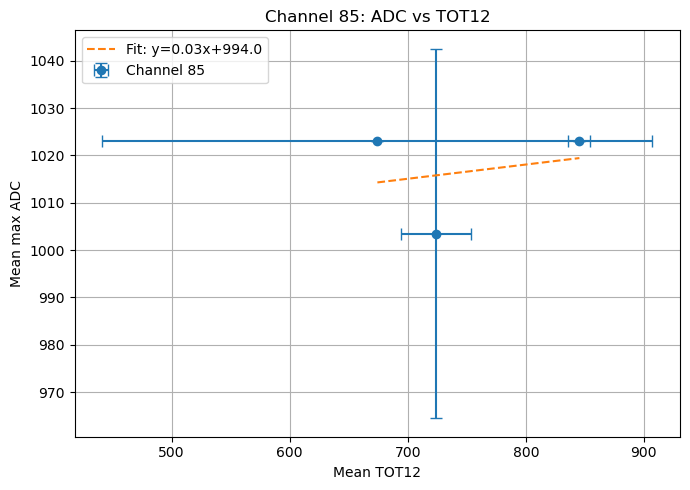

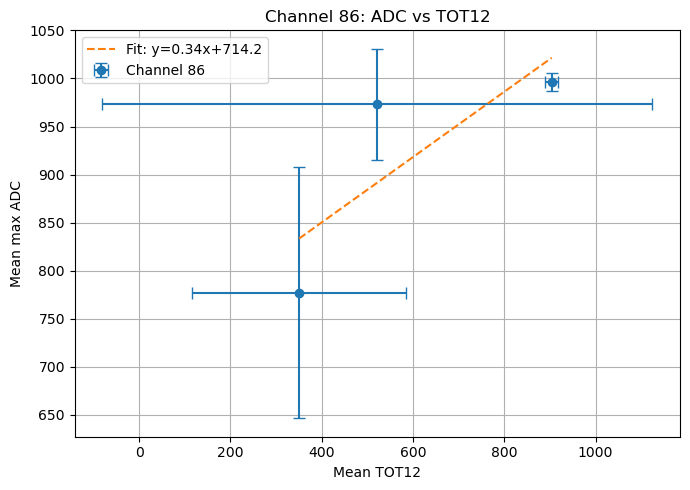

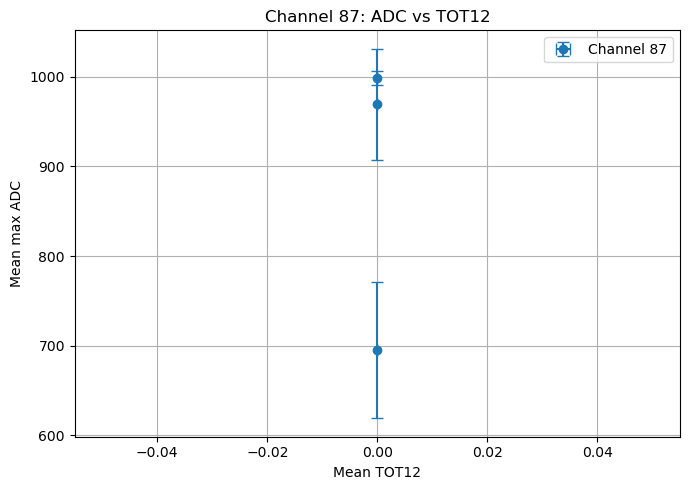

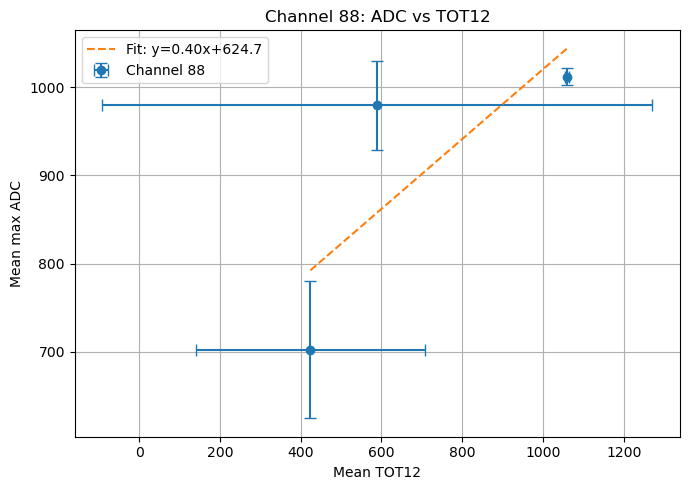

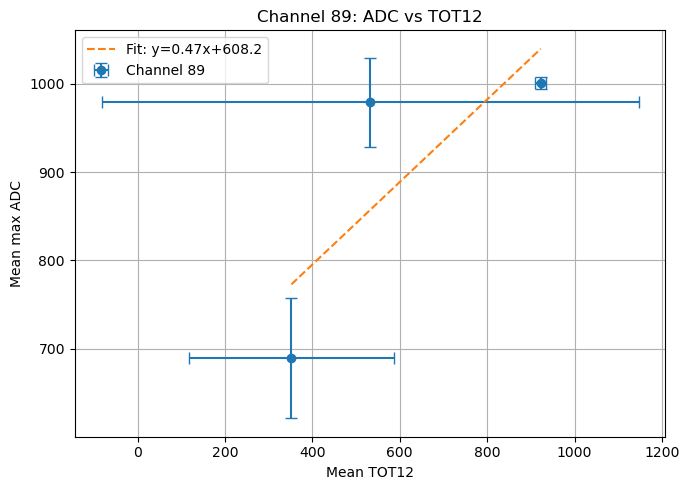

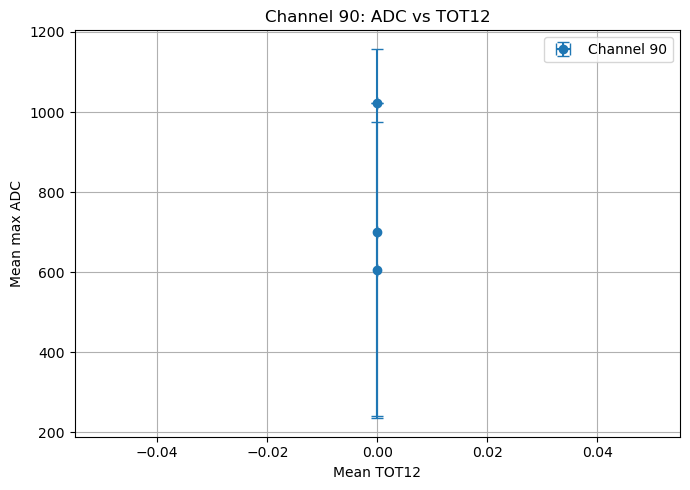

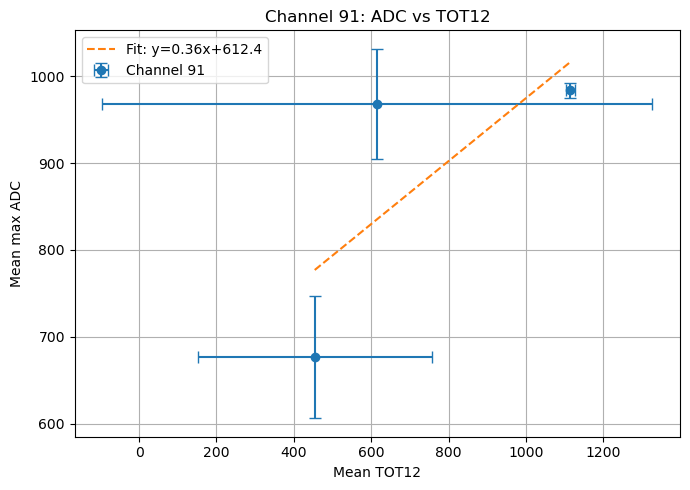

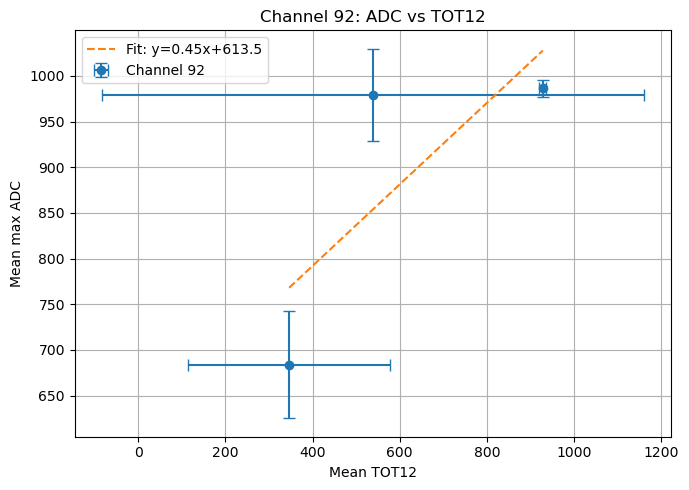

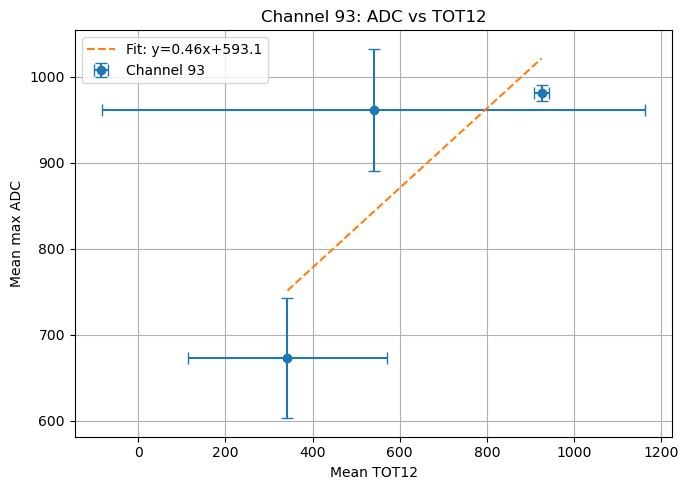

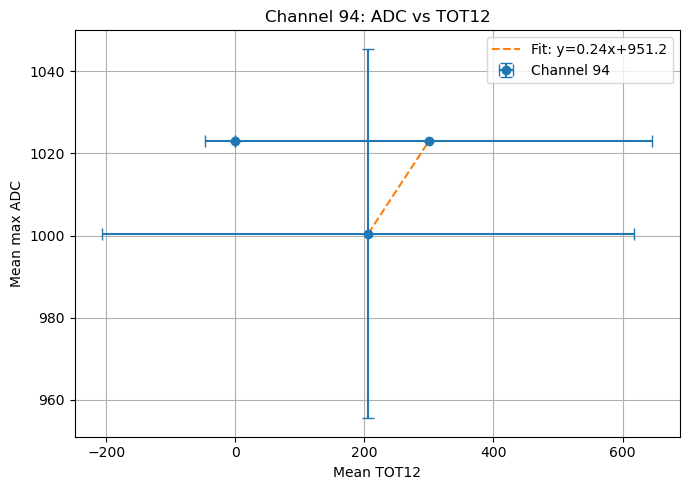

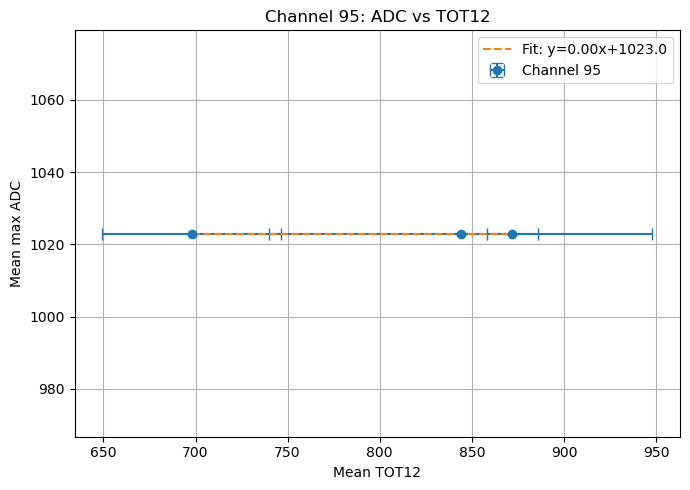

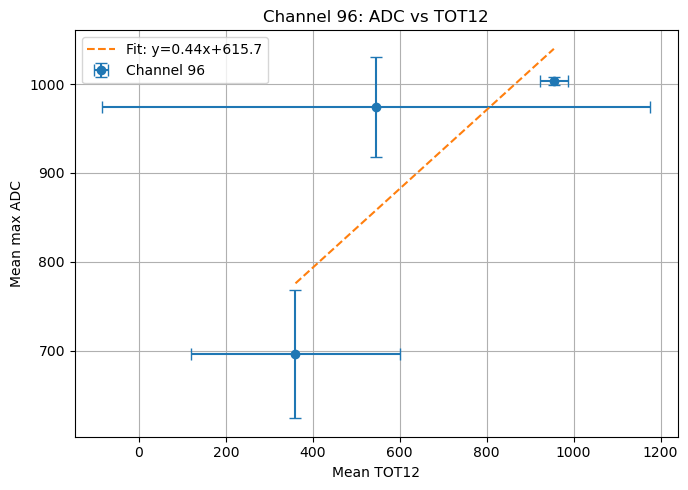

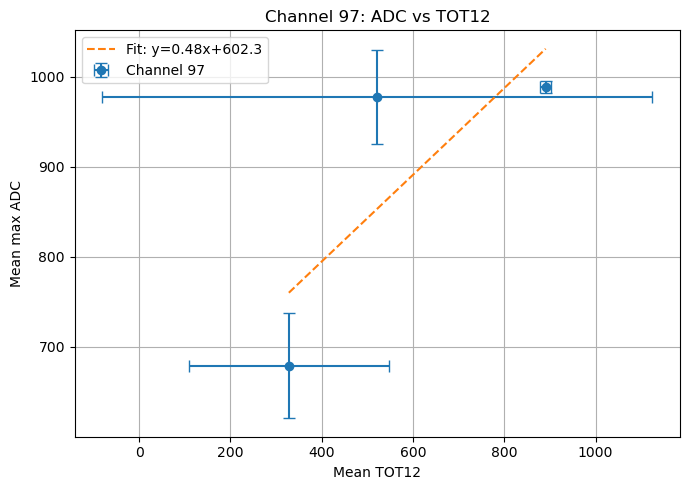

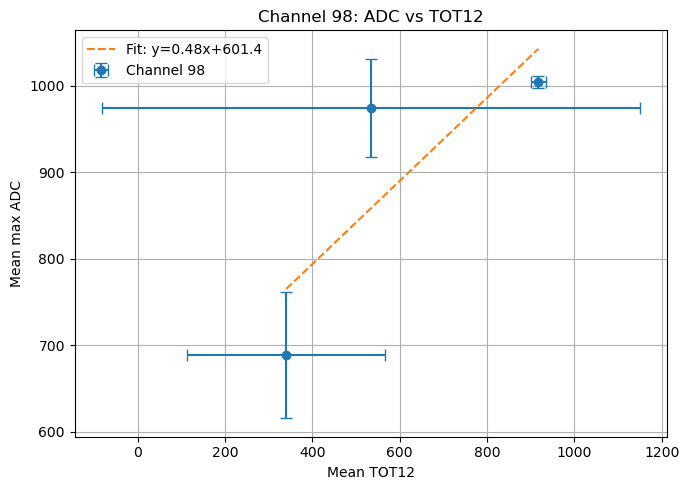

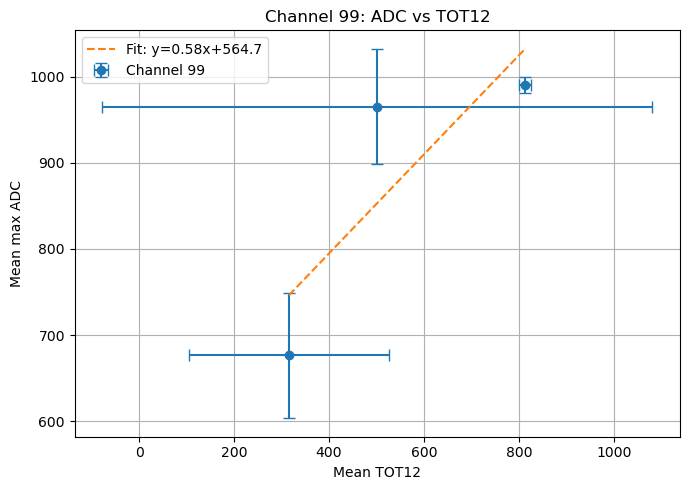

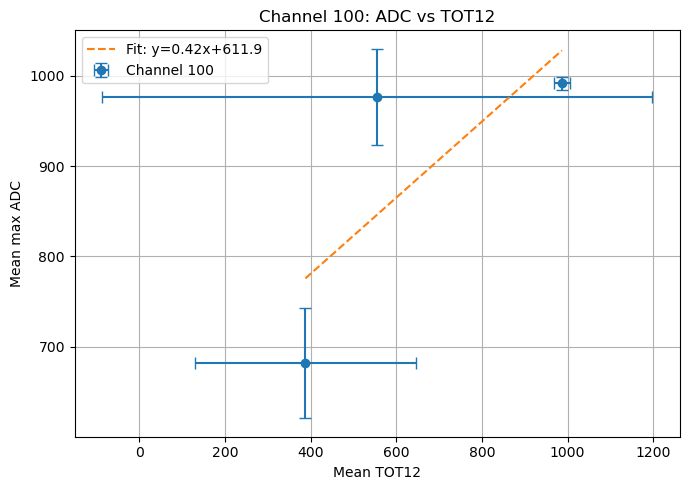

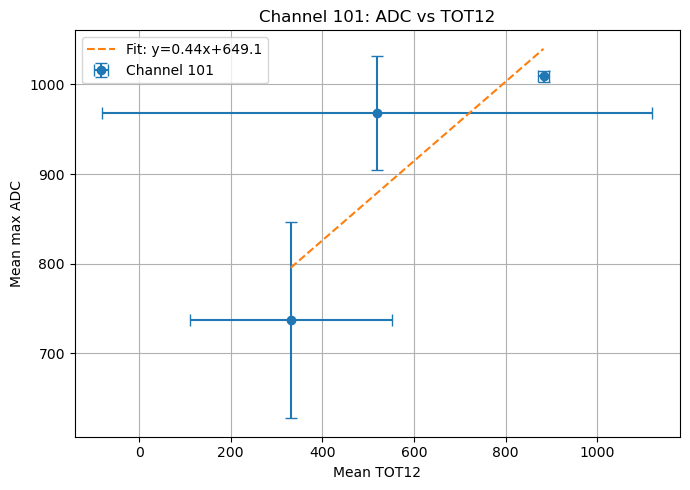

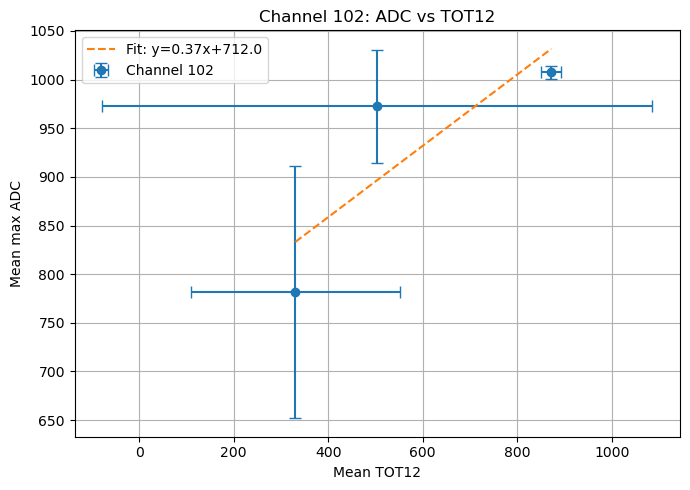

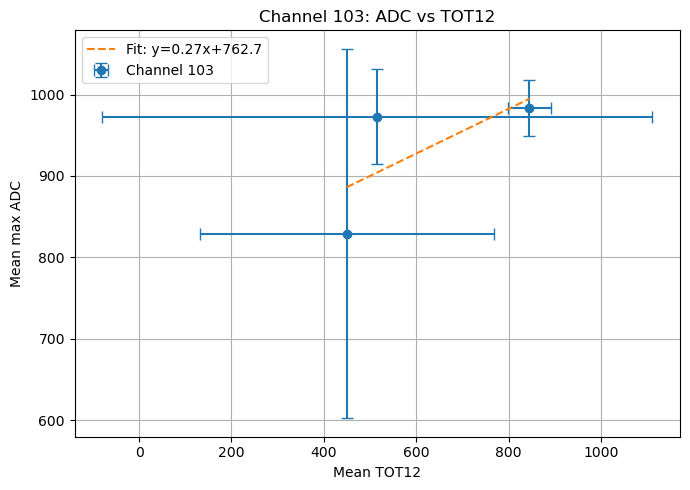

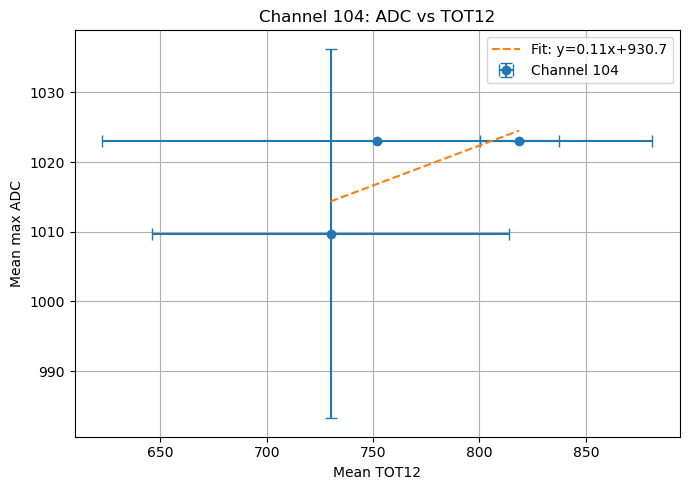

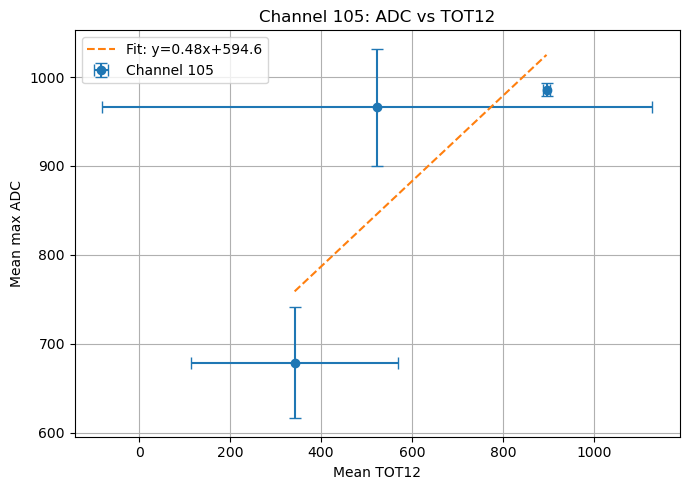

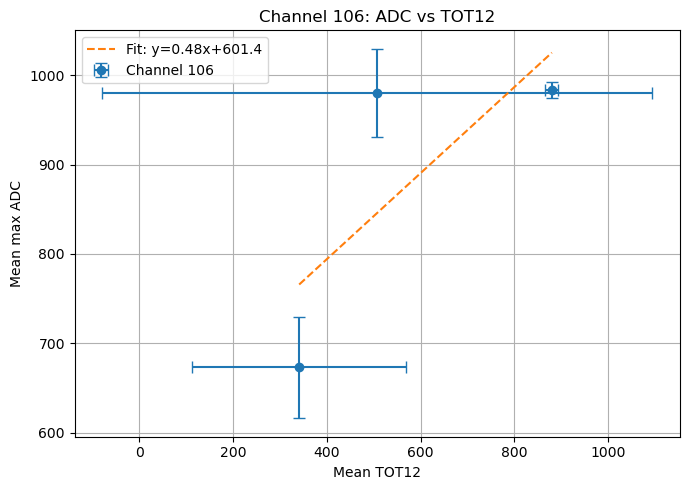

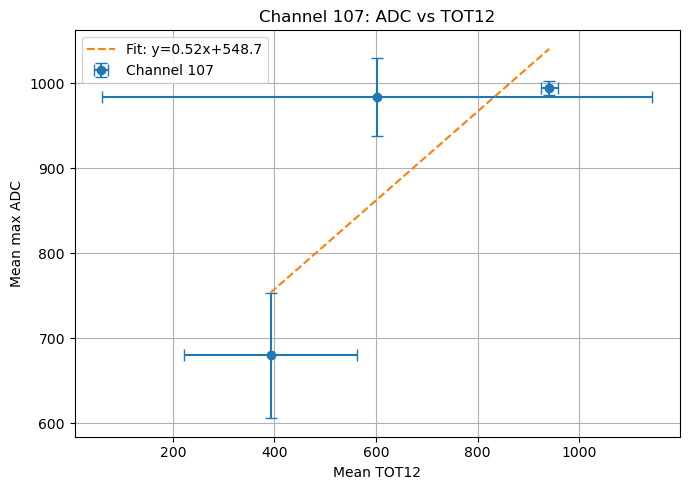

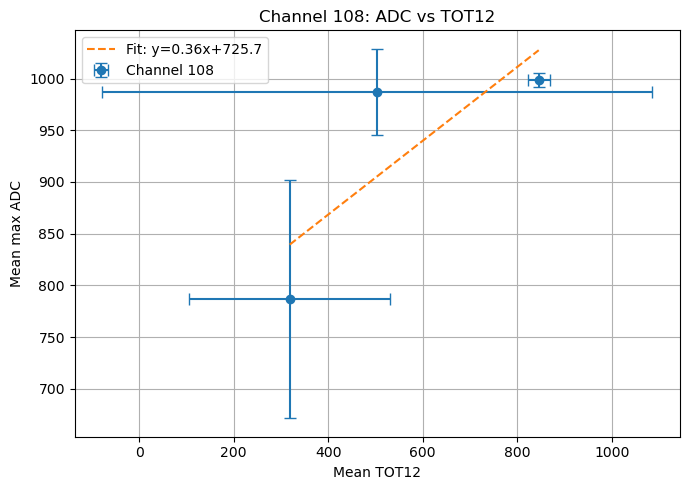

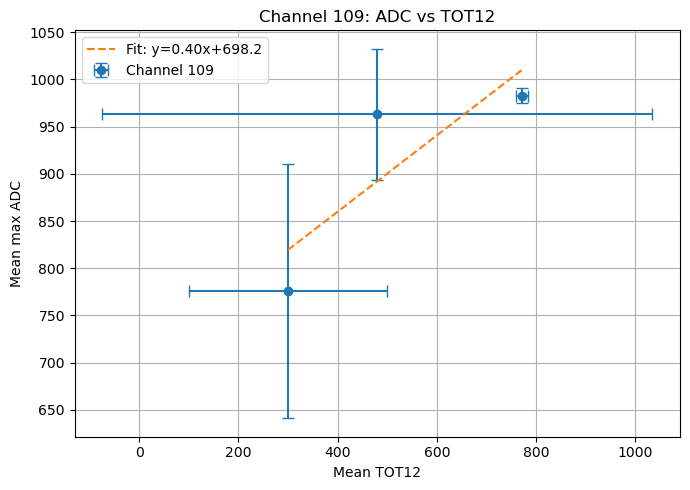

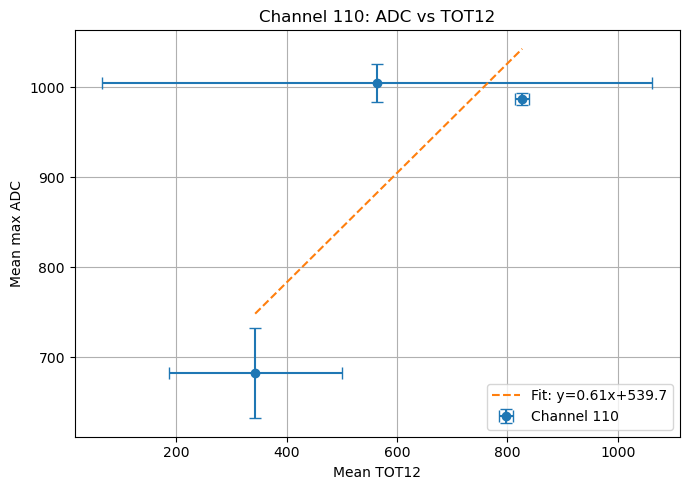

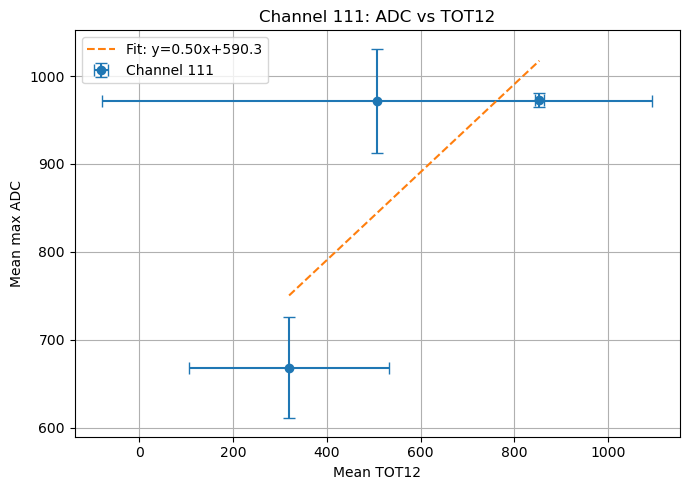

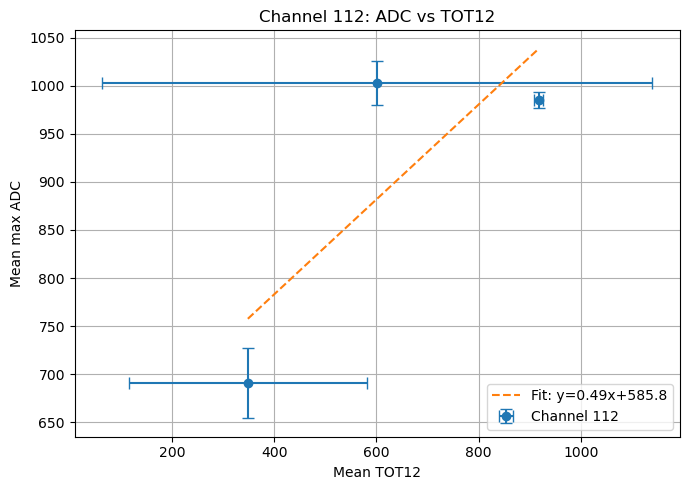

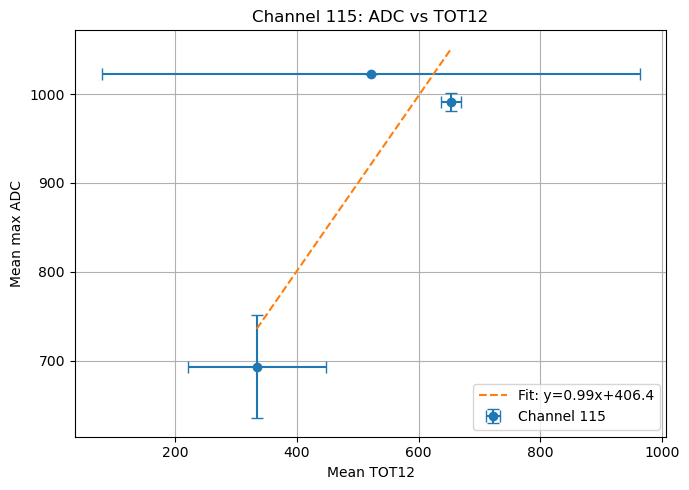

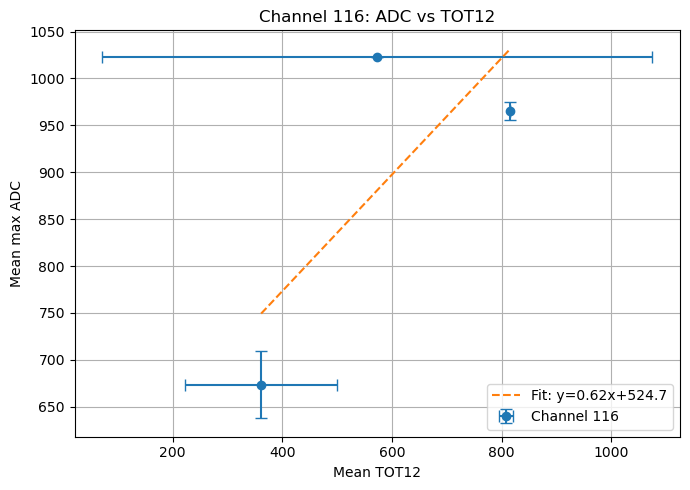

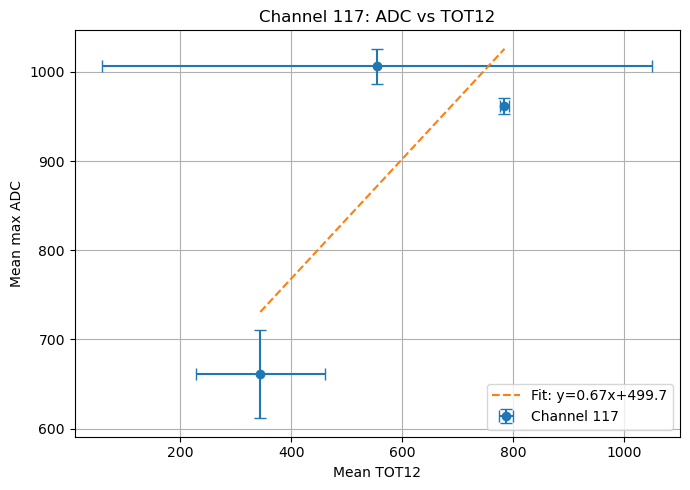

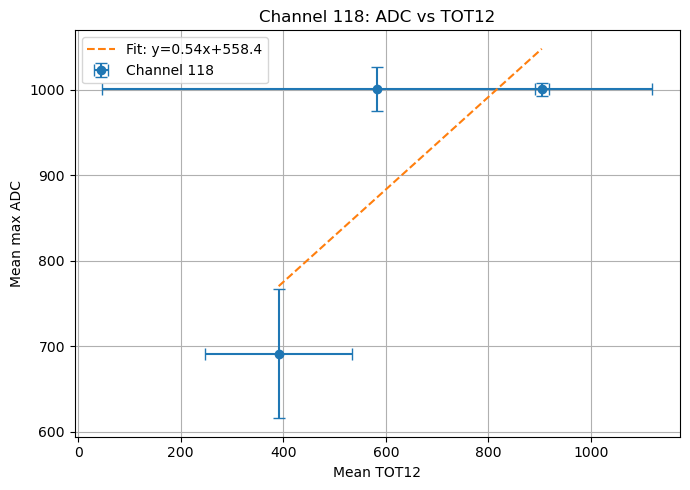

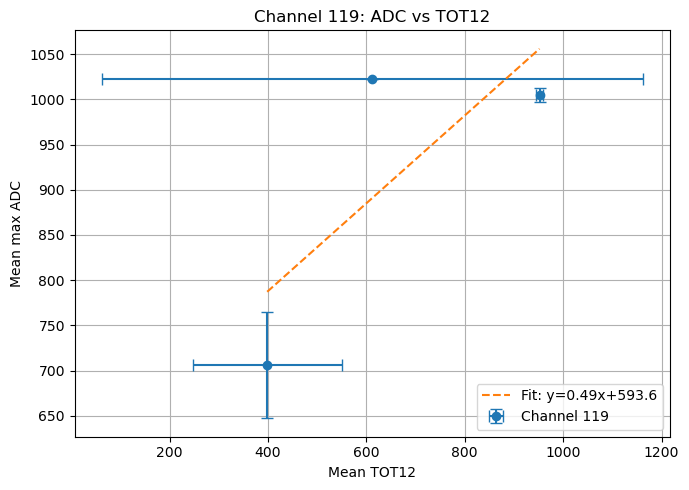

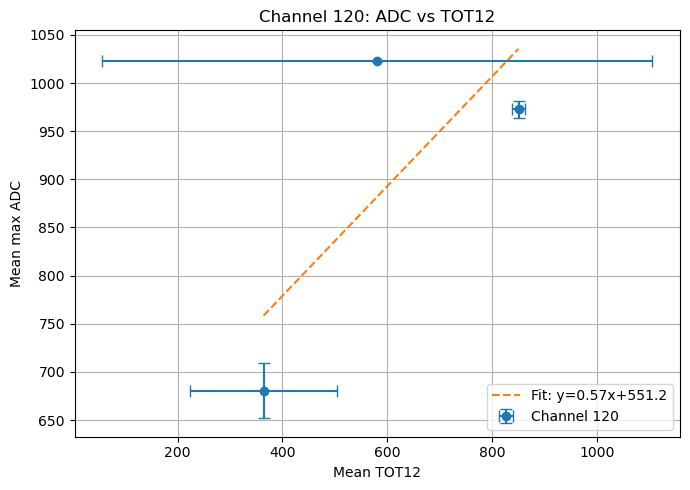

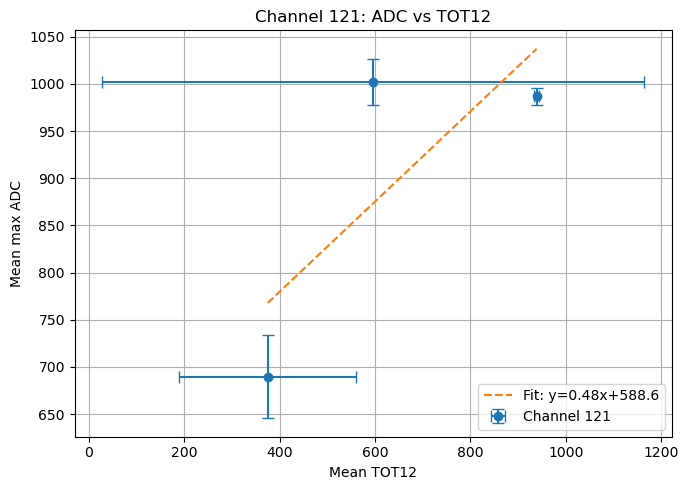

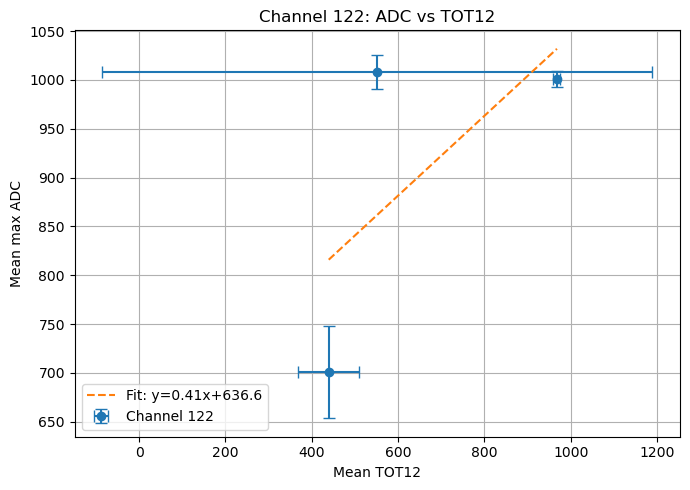

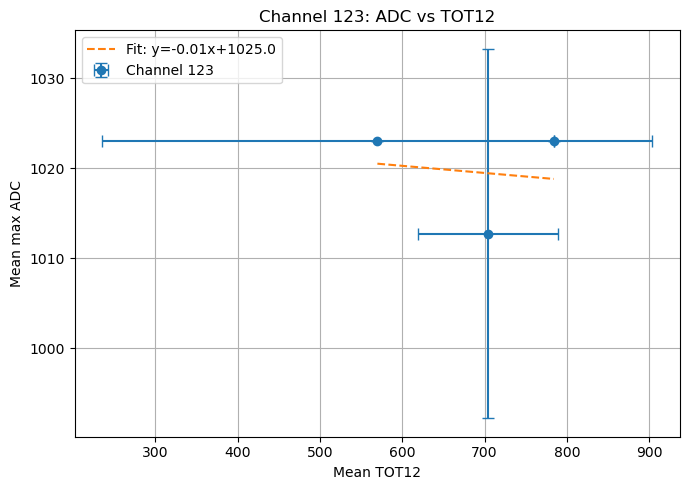

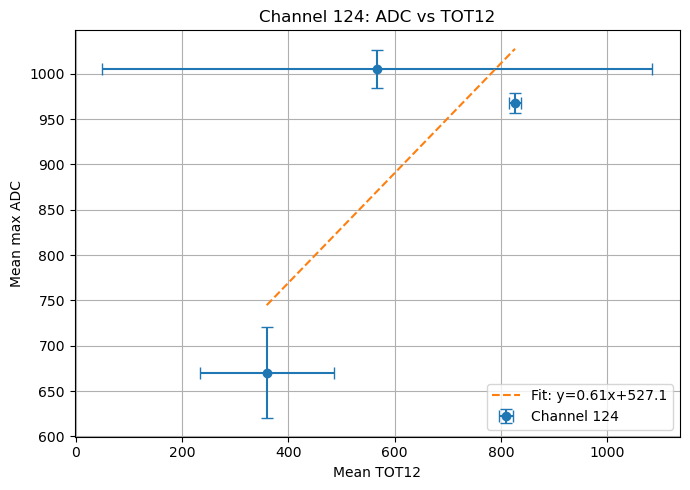

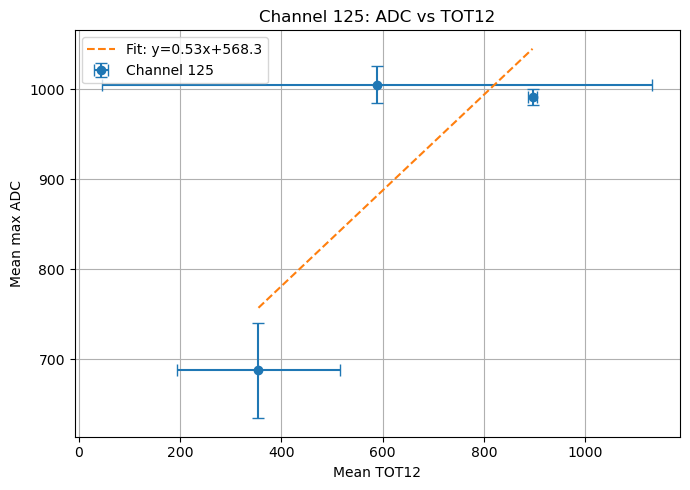

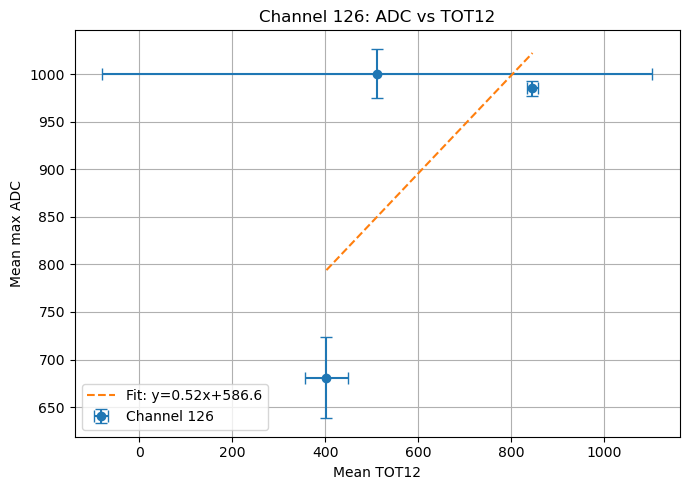

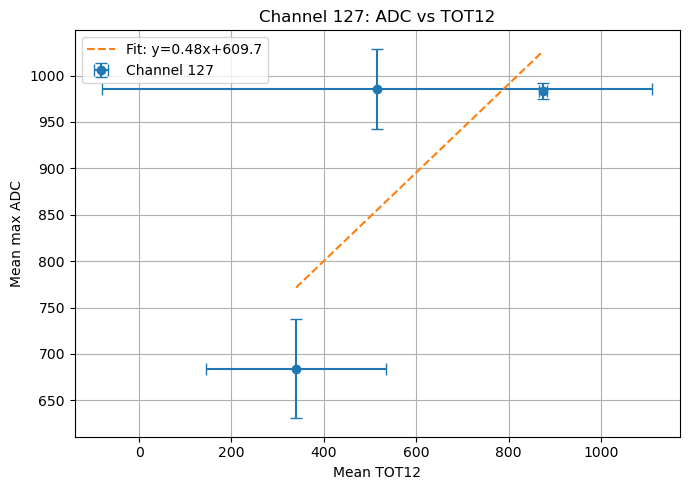

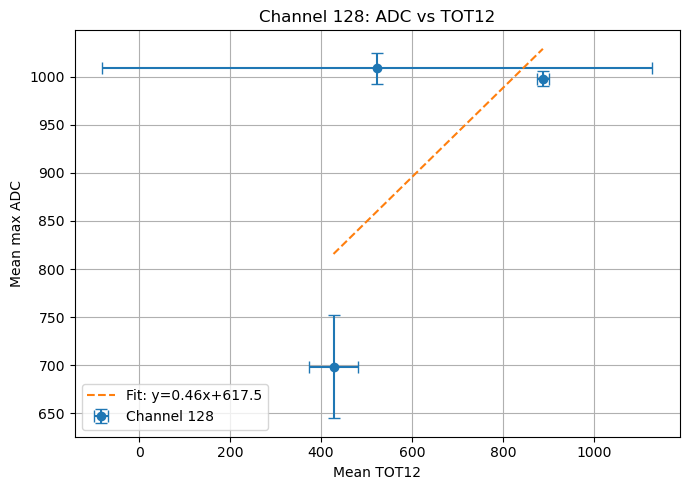

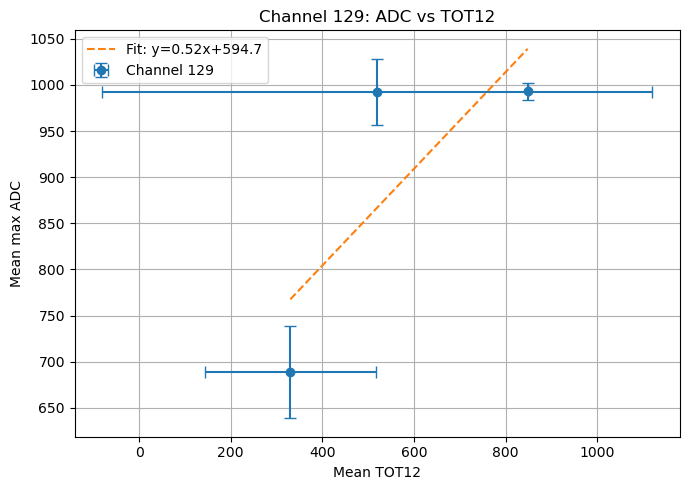

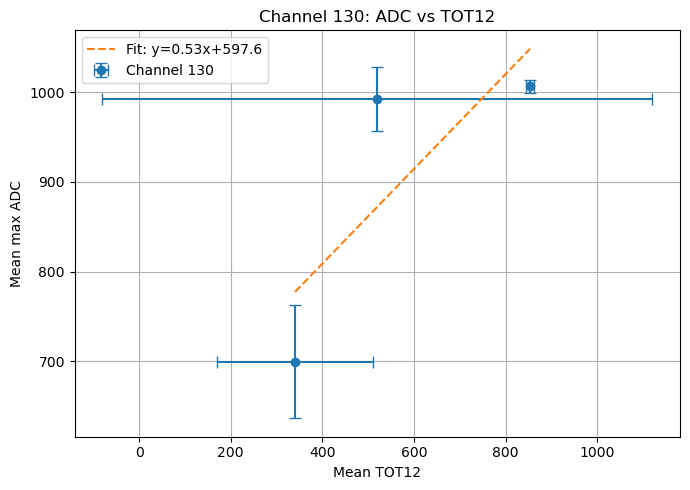

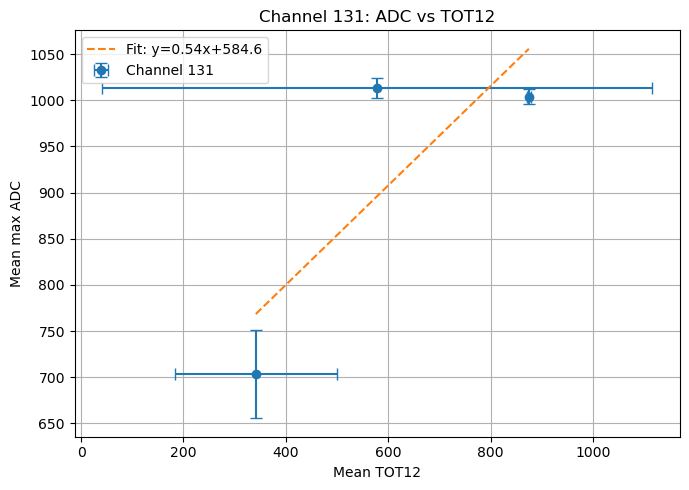

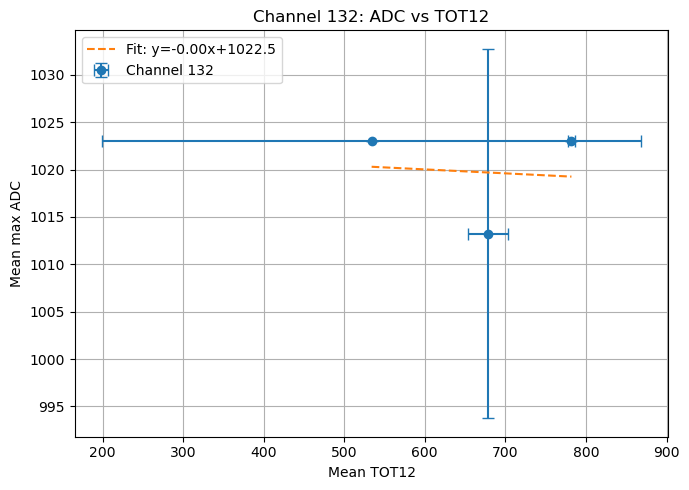

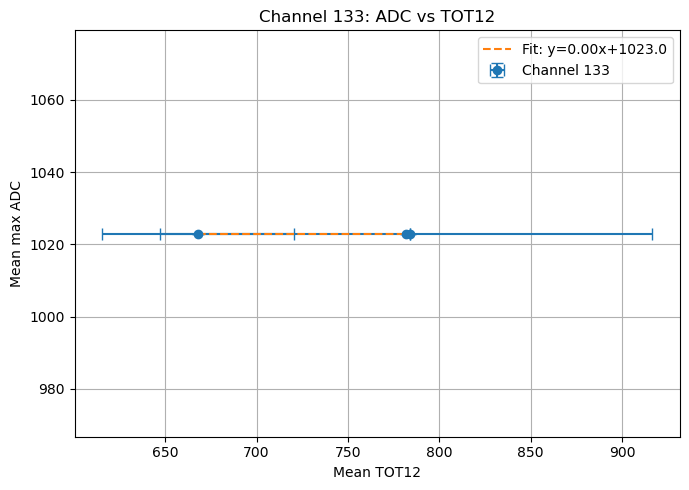

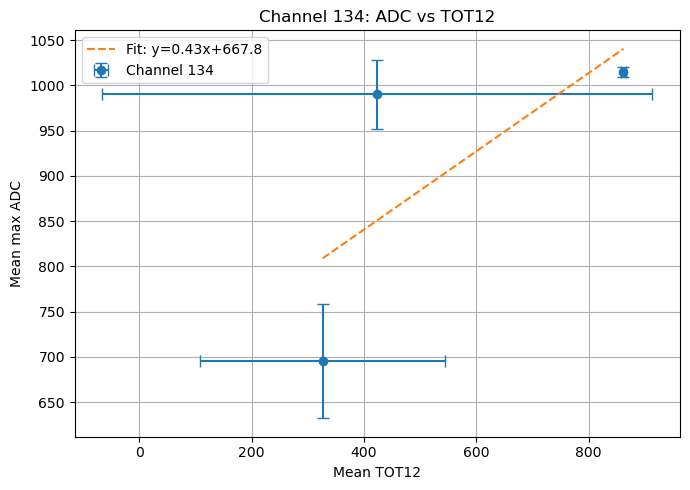

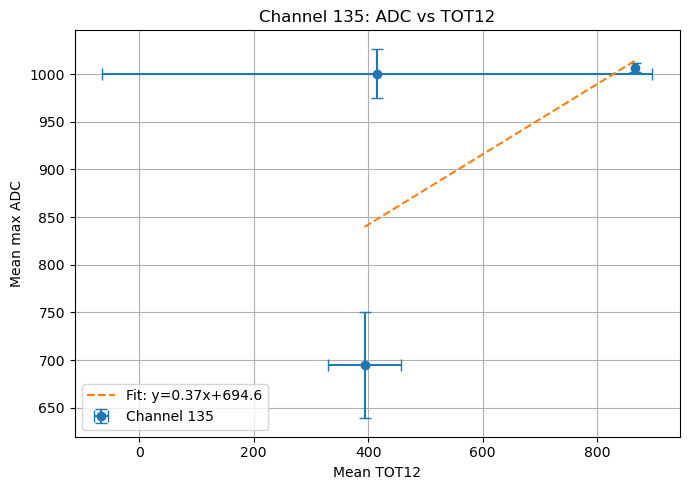

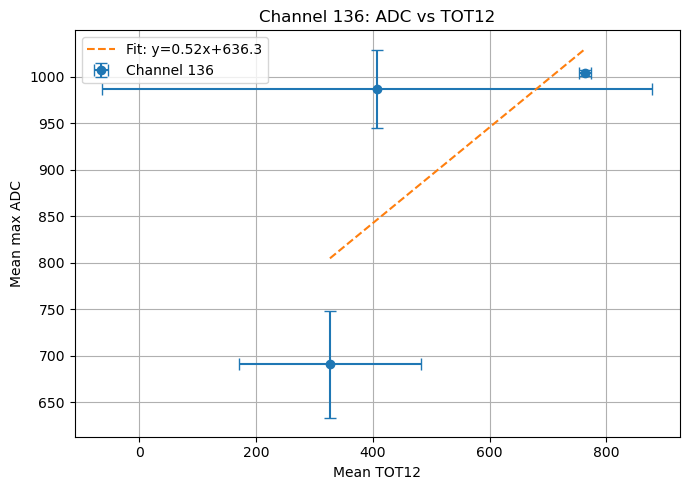

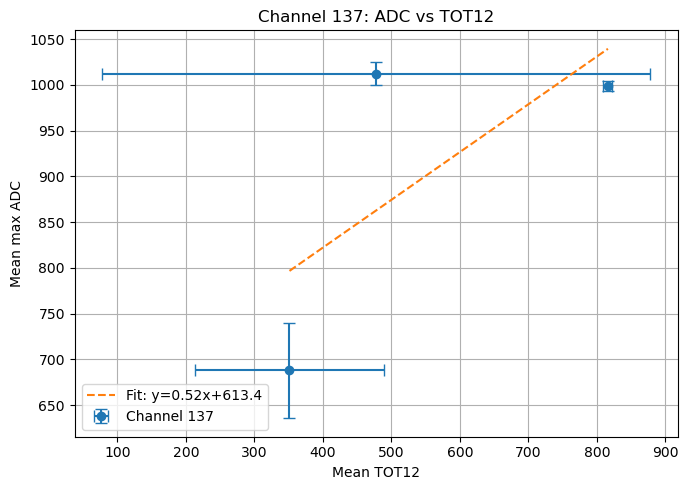

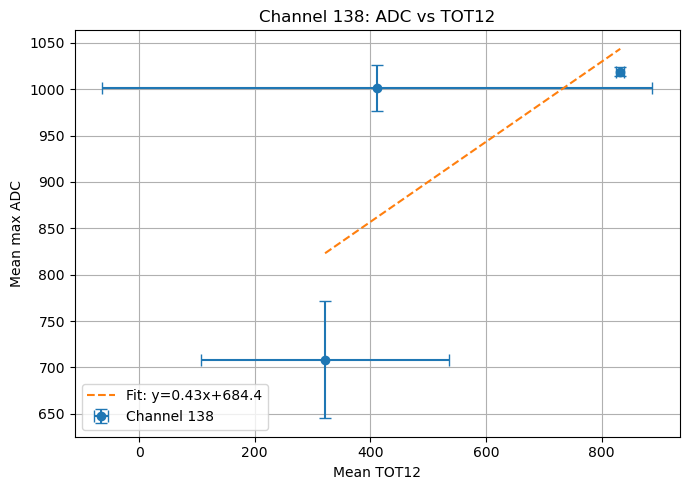

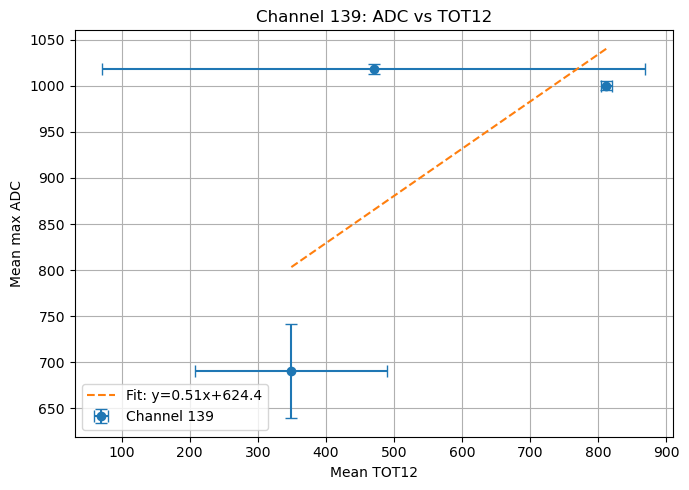

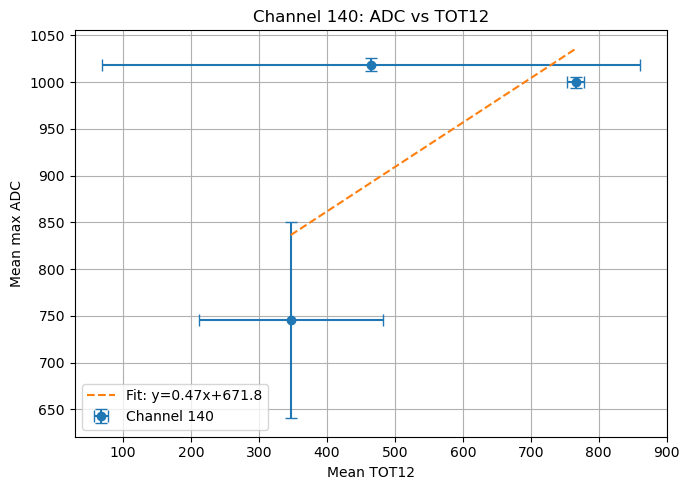

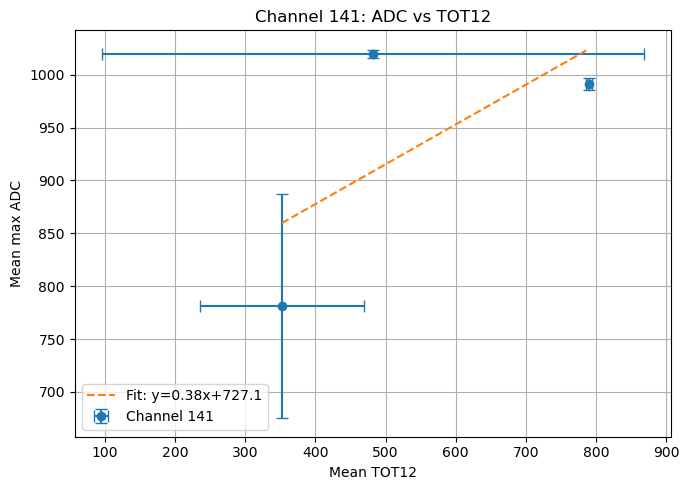

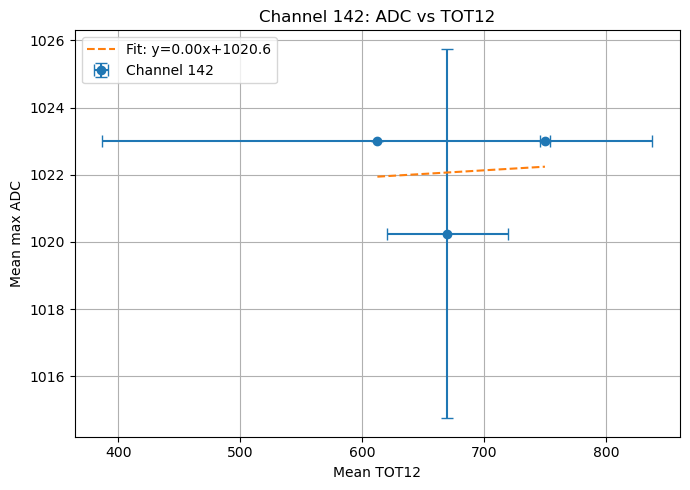

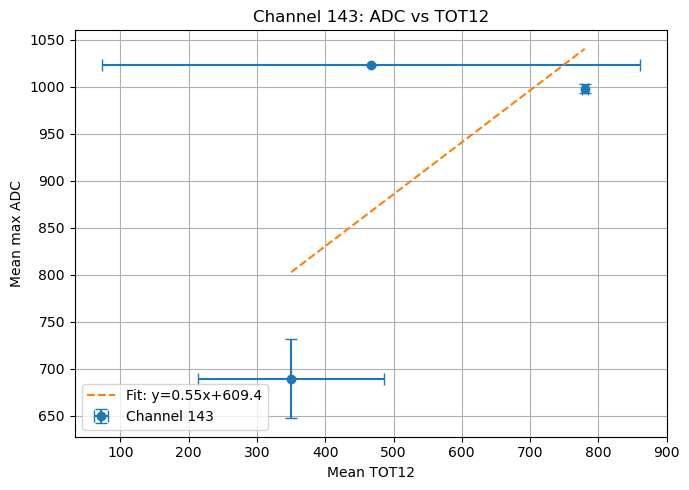

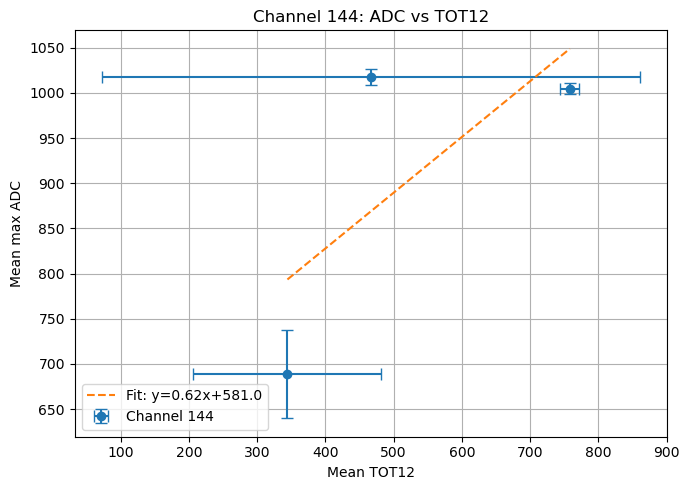

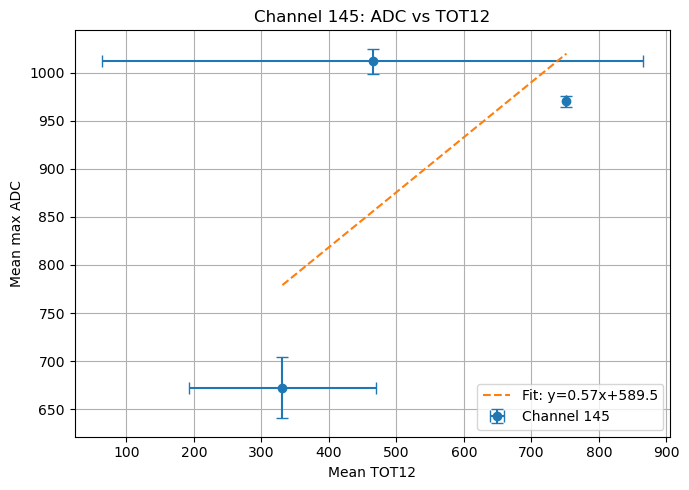

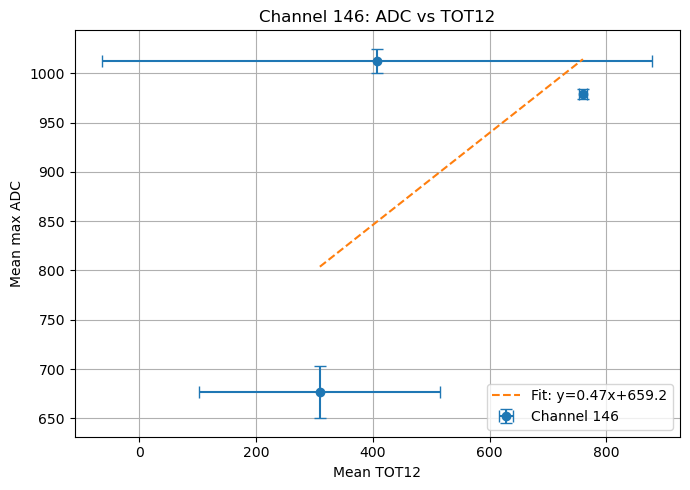

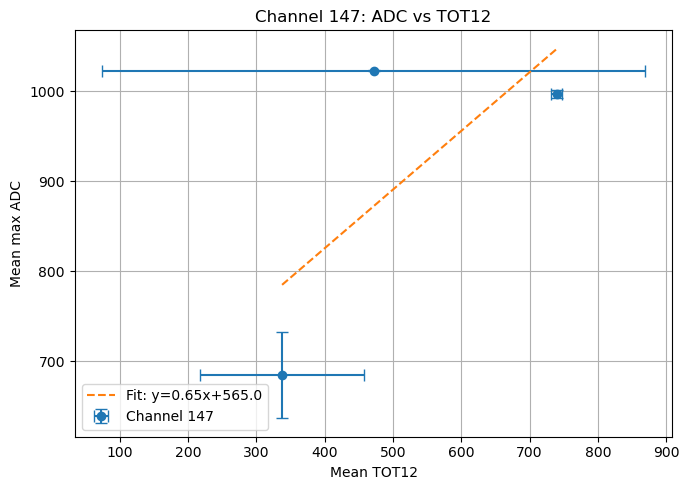

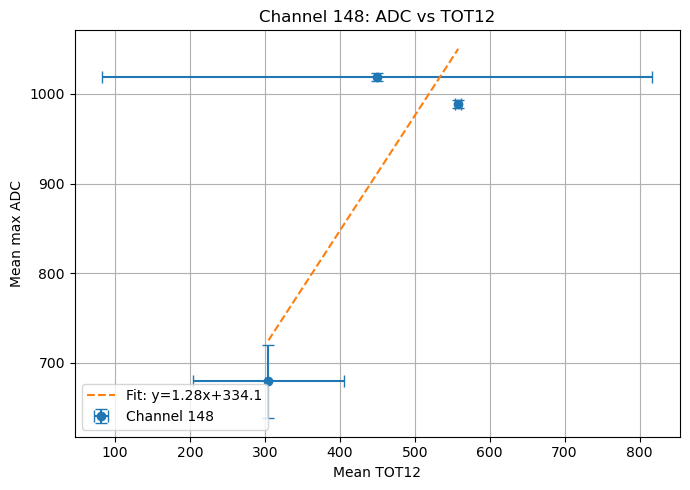

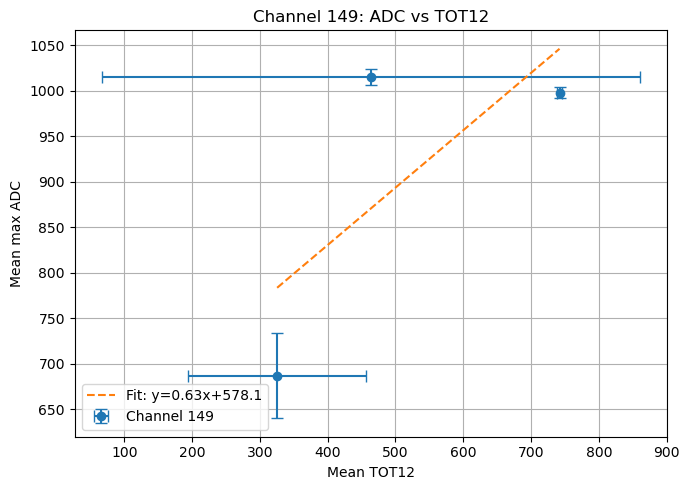

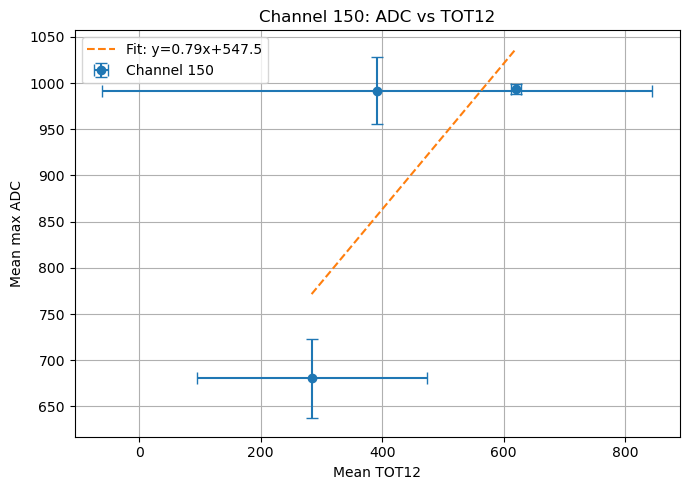

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

# === CONFIG ===
DAC_values = [300, 400, 450]
runs = range(5)

summary = []

for DAC in DAC_values:
    for RUN in runs:
        path = f"./{DAC}dac/inj_adc_samples_*_{DAC}_{RUN}*.csv"
        files = glob.glob(path)
        if not files:
            continue

        df = pd.read_csv(files[0])

        for ch in df["Channel"].unique():
            df_ch = df[df["Channel"] == ch]

            ADC_max = df_ch["ADC"].max()
            TOT_max = df_ch["TOT_12bit"].max()

            summary.append({
                "DAC": DAC,
                "Run": RUN,
                "Channel": ch,
                "ADC_max": ADC_max,
                "TOT12_max": TOT_max
            })

summary_df = pd.DataFrame(summary)

# === Compute mean and std per channel and DAC ===
agg = summary_df.groupby(["Channel", "DAC"]).agg(
    mean_ADC=("ADC_max", "mean"),
    std_ADC=("ADC_max", "std"),
    mean_TOT=("TOT12_max", "mean"),
    std_TOT=("TOT12_max", "std")
).reset_index()

print(agg.head())

# === Plot per channel ===
channels = agg["Channel"].unique()

for ch in channels:
    df_ch = agg[agg["Channel"] == ch]

    plt.figure(figsize=(7, 5))
    plt.errorbar(
        df_ch["mean_TOT"], df_ch["mean_ADC"],
        xerr=df_ch["std_TOT"], yerr=df_ch["std_ADC"],
        fmt="o", capsize=4, label=f"Channel {ch}"
    )

    # Linear fit (only if TOT > 0)
    df_valid = df_ch[df_ch["mean_TOT"] > 0]
    if len(df_valid) >= 2:
        slope, intercept = np.polyfit(df_valid["mean_TOT"], df_valid["mean_ADC"], 1)
        x_line = np.linspace(df_valid["mean_TOT"].min(), df_valid["mean_TOT"].max(), 100)
        plt.plot(x_line, slope*x_line + intercept, '--', label=f"Fit: y={slope:.2f}x+{intercept:.1f}")

    plt.xlabel("Mean TOT12")
    plt.ylabel("Mean max ADC")
    plt.title(f"Channel {ch}: ADC vs TOT12")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()